In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from evaluate import get_results, plot_confusion_matrix_multiclass, compute_plot_roc_multiclass

from sklearn.utils import shuffle, class_weight
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

# NB: clean up model output folder structure

In [2]:
# Extra imports
import feat_util
import librosa
import matplotlib.pyplot as plt

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
library = 'Keras'

if library == 'PyTorch':
    from PyTorch.runTorchMultiClass import train_model, load_model, evaluate_model, ResnetDropoutFull, Resnet, VGGishDropout
    from PyTorch import config_pytorch
elif library == 'Keras':
    from tensorflow import keras
    from Keras.runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ikiskin

In [4]:
# Select IHI Tanzania cup data to use for multi-species classification

df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [5]:
# Select list of classes with sufficient samples for significant analysis. Ordered with similar groups in adjacent classes.

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

# Create features (only re-run if not loading from pickle)

In [6]:
import collections
species_dict = collections.OrderedDict()
species_recordings = collections.OrderedDict()
for species in classes:
    # Number of total audio clips per species (includes repeats from same filename)
    species_recordings[species] = len(pd.unique(df_all[df_all.species==species].name)) # Number of unique audio recordings (and hence mosquitoes)
    species_dict[species] = sum(df_all[df_all.species==species].length)
    
# Divide recordings into train and test, with recording shuffling fixed by random_state
train_fraction = 0.75
train_recordings = {}
test_recordings = {}

# Random seeds for 5-fold CV results
random_seeds = [42, 21, 5, 10, 100] # Paper results for 5-fold CV.
 
random_seed = 100  # Select specifc random seed here.

for i in range(len(classes)):
    n_train = int(species_recordings[classes[i]] * train_fraction)
    n_test = species_recordings[classes[i]] - n_train
    print(classes[i], n_train, n_test)
    df_class = df_all[df_all.species == classes[i]]
    train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
    test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]

an arabiensis 385 129
culex pipiens complex 252 84
ae aegypti 36 13
an funestus ss 186 62
an squamosus 68 23
an coustani 37 13
ma uniformis 57 19
ma africanus 28 10


In [10]:
# Features for VGGish input: 96x64 (W*H) log-mel spectrogram
from feat_vggish import get_feat_multispecies, reshape_feat
# Features for all other models using default log-mel implementation:
# from feat_util import 

In [ ]:
def get_feat_multispecies(df_all, label_recordings_dict, data_dir, rate, n_feat):
    '''Extract features for multi-class species classification.'''
    X = []
    y = []

    for class_label in label_recordings_dict.keys(): # Loop over classes
        print('Extracting features for class:', class_label)
        for i in label_recordings_dict[class_label]: # Loop over recordings in class
            df_match = df_all[df_all.name == i]
            for idx, row in df_match.iterrows(): # Loop over clips in recording
                _, file_format = os.path.splitext(row['name'])
                filename = os.path.join(data_dir, str(row['id']) + file_format)
                signal, rate = librosa.load(filename, sr=rate)
                feat = librosa.feature.melspectrogram(signal, sr=rate, n_mels=n_feat) 
#                 feat = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=n_feat)
                feat = librosa.power_to_db(feat, ref=np.max)
                if config.norm_per_sample:
                    feat = (feat-np.mean(feat))/np.std(feat)                
                X.append(feat)
                y.append(class_label)
    return X, y

In [20]:
# Run for VGGish:
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)

Extracting features for class: 0
Extracting features for class: 1
Extracting features for class: 2
Extracting features for class: 3
Extracting features for class: 4
Extracting features for class: 5
Extracting features for class: 6
Extracting features for class: 7


In [21]:
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

Extracting features for class: 0
Extracting features for class: 1
Extracting features for class: 2
Extracting features for class: 3
Extracting features for class: 4
Extracting features for class: 5
Extracting features for class: 6
Extracting features for class: 7


In [20]:
# X_test_CNN, y_test_CNN = reshape_feat(X_test, y_test)

In [21]:
# X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)

In [22]:
# Save feature output to pickle VGGish: Save before reshape to allow us to evaluate recording aggregate and individual windows.

import pickle
pickle_name_train = 'vggish_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_' + str(random_seed) + '_test.pickle'

feat_train = {"X_train":X_train, "y_train":y_train}
feat_test = {"X_test":X_test, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

Saved features to: ../outputs/features/multi-species/humbugdb\vggish_100_train.pickle
Saved features to: ../outputs/features/multi-species/humbugdb\vggish_100_test.pickle


In [36]:
# Load VGGish pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'vggish_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_' + str(random_seed) + '_test.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    feat_test = pickle.load(input_file)
    
X_train = feat_train["X_train"]
y_train = feat_train["y_train"]
X_test = feat_test["X_test"]
y_test = feat_test["y_test"]
# Returns features with correct dimensions for VGGish16.


In [37]:
# Convert VGGish PyTorch format pickles to regular numpy arrays:

############

X_list = []

for feat in X_train:
    X_list.append(feat.cpu().detach().numpy())

X_te_list = []

for feat in X_test:
    X_te_list.append(feat.cpu().detach().numpy())


In [38]:
pickle_name_train = 'vggish_keras_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_keras_' + str(random_seed) + '_test.pickle'

feat_train = {"X_train":X_list, "y_train":y_train}
feat_test = {"X_test":X_te_list, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

Saved features to: ../outputs/features/multi-species/humbugdb\vggish_keras_100_train.pickle
Saved features to: ../outputs/features/multi-species/humbugdb\vggish_keras_100_test.pickle


In [39]:
X_train = X_list
X_test = X_te_list
#TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray (when reshaping numpy arrays: fix this after)

In [7]:
# Load VGGish_Keras pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'vggish_keras_' + str(random_seed) + '_train.pickle'
pickle_name_test = 'vggish_keras_' + str(random_seed) + '_test.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    feat_test = pickle.load(input_file)
    
X_train = feat_train["X_train"]
y_train = feat_train["y_train"]
X_test = feat_test["X_test"]
y_test = feat_test["y_test"]
# Returns features with correct dimensions for VGGish16.

In [12]:
import matplotlib.pyplot as plt

In [9]:
X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)

In [9]:
# Converting VGGish feats to keras compatibility

def reshape_feat(feats, labels):
    y_full = []
    for idx, feat in enumerate(feats):
        y_full.append(np.repeat(labels[idx], np.shape(feat)[0]))
    y = np.concatenate(y_full)
    
    X = np.vstack(feats)
    return X, y
    
    

In [42]:
np.shape(X_test[400][0])

(1, 96, 64)

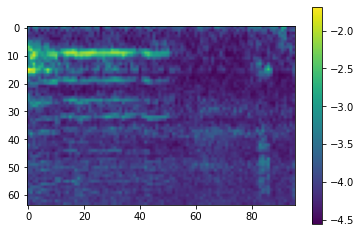

In [47]:
plt.imshow(X_test[100][0].squeeze().T)
plt.colorbar()

In [ ]:
# Extract feats, expected runtime ~5 mins
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)
# Extract feats, expected runtime ~14 mins
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

# Save features to pickle

In [ ]:
# Save feature output to pickle

import pickle
pickle_name_train = 'log_mel_feat_shuffle_' + str(random_seed) + '_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_' + str(random_seed) + '_test_norm_'+str(config.norm_per_sample)+'.pickle'

log_mel_feat_train = {"X_train":X_train, "y_train":y_train}
log_mel_feat_test = {"X_test":X_test, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(log_mel_feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(log_mel_feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

# Load pickled features

In [8]:
# Load pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'log_mel_feat_shuffle_' + str(random_seed) + '_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_' + str(random_seed) + '_test_norm_'+str(config.norm_per_sample)+'.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    log_mel_feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    log_mel_feat_test = pickle.load(input_file)
    
X_train = log_mel_feat_train["X_train"]
y_train = log_mel_feat_train["y_train"]
X_test = log_mel_feat_test["X_test"]
y_test = log_mel_feat_test["y_test"]
# Reshape features to be used with CNN (Keras or PyTorch)

X_train_CNN, y_train_CNN = feat_util.reshape_feat(X_train, y_train, config.win_size, config.step_size)
X_test_CNN, y_test_CNN = feat_util.reshape_feat(X_test, y_test, config.win_size, config.win_size)

Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of recording shorter than supplied window size.
Length of 

ValueError: need at least one array to concatenate

# Model definition and optimisation
Current model here is identical to the model used in paper for previous results with binary mosquito/noise detection. Acts as good baseline for further work.

In [10]:
X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)



Epoch 1/80
28018/28018 [==============================] - 10s 347us/step - loss: 1.6872 - accuracy: 0.3855
Epoch 2/80
28018/28018 [==============================] - 8s 301us/step - loss: 1.4969 - accuracy: 0.4491
Epoch 3/80
28018/28018 [==============================] - 8s 301us/step - loss: 1.3557 - accuracy: 0.4970
Epoch 4/80
28018/28018 [==============================] - 8s 303us/step - loss: 1.2347 - accuracy: 0.5394
Epoch 5/80
28018/28018 [==============================] - 9s 310us/step - loss: 1.1574 - accuracy: 0.5667
Epoch 6/80
28018/28018 [==============================] - 8s 303us/step - loss: 1.0953 - accuracy: 0.5893
Epoch 7/80
28018/28018 [==============================] - 8s 299us/step - loss: 1.0375 - accuracy: 0.6115
Epoch 8/80
28018/28018 [==============================] - 9s 305us/step - loss: 0.9865 - accuracy: 0.6328
Epoch 9/80
28018/28018 [==============================] - 8s 301us/step - loss: 0.9400 - accuracy: 0.6472
Epoch 10/80
28018/28018 [==================

28018/28018 [==============================] - 9s 303us/step - loss: 0.1464 - accuracy: 0.9487
Epoch 74/80
28018/28018 [==============================] - 9s 309us/step - loss: 0.1456 - accuracy: 0.9526
Epoch 75/80
28018/28018 [==============================] - 9s 309us/step - loss: 0.1428 - accuracy: 0.9508
Epoch 76/80
28018/28018 [==============================] - 8s 302us/step - loss: 0.1511 - accuracy: 0.9491
Epoch 77/80
28018/28018 [==============================] - 8s 303us/step - loss: 0.1471 - accuracy: 0.9511
Epoch 78/80
28018/28018 [==============================] - 8s 300us/step - loss: 0.1432 - accuracy: 0.9517
Epoch 79/80
28018/28018 [==============================] - 8s 302us/step - loss: 0.1475 - accuracy: 0.9501
Epoch 80/80
28018/28018 [==============================] - 9s 304us/step - loss: 0.1438 - accuracy: 0.9527


In [13]:
X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train)),y=np.array(y_train))
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights, model = ResnetDropoutFull(n_classes = 8, dropout=0.05))

F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Training on cuda:0
Applying class weights: [0.34766881 0.522343   3.18014706 0.74568966 1.96590909 3.37890625
 2.07932692 3.72844828]
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e0_2021_08_18_12_48_48.pth
Epoch: 0, Train Loss: 1.77796413, Train Acc: 0.29395655, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e1_2021_08_18_12_49_12.pth
Epoch: 1, Train Loss: 1.31239525, Train Acc: 0.45331386, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e2_2021_08_18_12_49_35.pth
Epoch: 2, Train Loss: 1.13265143, Train Acc: 0.51798430, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e3_2021_08_18_12_49_58.pth
Epoch: 3, Train Loss: 1.00111089, Train Acc: 0.56399489, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e4_2021_08_18_12_50_22.pth
E

all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e45_2021_08_18_13_06_44.pth
Epoch: 45, Train Loss: 0.11604108, Train Acc: 0.93715538, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e46_2021_08_18_13_07_08.pth
Epoch: 46, Train Loss: 0.11149137, Train Acc: 0.93777615, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e47_2021_08_18_13_07_33.pth
Epoch: 47, Train Loss: 0.11200605, Train Acc: 0.93781267, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e48_2021_08_18_13_07_57.pth
Epoch: 48, Train Loss: 0.11896557, Train Acc: 0.93876210, overrun_counter 0
all_y all_y_pred (27385, 1) (27385,)
Epoch: 49, Train Loss: 0.12733786, Train Acc: 0.93368632, overrun_counter 1
all_y all_y_pred (27385, 1) (27385,)
Saving model to: ..\outputs\models\pytorch\model_e50_2021_08_18_13_08_46.pth
Epoch: 50, Tr

In [ ]:
# model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights, model = Resnet(n_classes = 8, dropout=0.2))

In [ ]:
# Compute class weights to weight by inverse of class frequency
# weights = torch.tensor(class_weights)  # Torch does not use dict for class weights
# class_weights = dict(enumerate(class_weights.flatten()))  # Dict to support both older and newer Keras API

# Load model from checkpoint
## (optional)

In [14]:
# Select checkpoint to load model (optional)
# Following filepath used for results on 26/07/: model results from paper
filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'

# ResNet-50 BNN
# filepath = '../outputs/models/pytorch/model_e72_2021_07_29_22_10_30.pth'

#30th July overnight training:
filepath = '../outputs/models/pytorch/model_e91_2021_07_30_05_40_54.pth'

# 30th July day training ResNet-18 BNN
filepath = '../outputs/models/pytorch/model_e83_2021_07_30_20_45_11.pth'


# VGGish16:
# fIRST poor attempt. model_e10_2021_08_04_22_39_37.pth


# 31st July 2 AM Next random seed: 21
filepath = '../outputs/models/pytorch/model_e78_2021_07_31_02_00_40.pth'
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_02_31_05-e77accuracy0.9633.hdf5'
# Resnet50: model_e14_2021_08_03_11_51_30.pth'
#VGGish:
filepath = '../outputs/models/pytorch/model_e26_2021_08_05_22_41_33.pth'

# 31st July 2:30-3:30 AM, random seed: 5
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_03_25_35-e69accuracy0.9608.hdf5'
# second option: filepath = Win_30_Stride_5_2021_08_03_00_07_38-e43accuracy0.9621.hdf5 # 
#ResNet18:
# Training started 17:48 31/07: dropout 0.05 inside, 0.2 outside:
filepath = '../outputs/models/pytorch/model_e77_2021_07_31_20_01_44.pth'


# Training at 14:55 02/08, dropout 0.2 fixed
filepath = '../outputs/models/pytorch/model_e98_2021_08_02_15_00_40.pth'

# ResNet18 0.05 dropout everywhere
filepath = '../outputs/models/pytorch/model_e98_2021_08_02_18_44_03.pth'



#ResNet50
filepath = '../outputs/models/pytorch/model_e71_2021_08_01_04_23_48.pth'
#ResNet50NoDropout (run 1, collapsed after this epoch)
filepath = '../outputs/models/pytorch/model_e73_2021_08_01_18_19_10.pth'
#ResNet50NoDropout (run 2, ensured code correct for this rim)
filepath = '../outputs/models/pytorch/model_e91_2021_08_02_01_26_12.pth' 
# 02/aug/21 2:06 AM


#random seed: 10
#Keras:
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_03_09_42_31-e60accuracy0.9614.hdf5'

# ResNet18:
filepath = '../outputs/models/pytorch/model_e86_2021_08_02_22_14_16.pth'
#ResNet50
# very poor: dropout 0.2 fixed loss: model_e68_2021_08_03_07_04_28.pth
#16th Aug: new attempt:
filepath = '../outputs/models/pytorch/model_e35_2021_08_16_15_48_41.pth'


filepath = '../outputs/models/pytorch/model_e033_2021_08_17_11_40_29.pth'

model = load_model(filepath, model=VGGishDropout(n_classes=8, dropout=0.05))



# # random seed 100
# # Keras:
# filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_13_20_53-e68accuracy0.9601.hdf5'
# #ResNet18:
# filepath = '../outputs/models/keras/model_e99_2021_07_31_16_58_14.pth'

# #ResNet50 (dropout last layer strictly only)
# # training now: 02 Aug 21, started 2:08 AM
# filepath = '../outputs/models/pytorch/model_e85_2021_08_02_07_17_14.pth'


# #2am7aug resnet18dropout0.05
filepath = '../outputs/models/pytorch/model_e97_2021_08_18_13_26_57.pth'

model = load_model(filepath, model=ResnetDropoutFull(n_classes=8, dropout=0.05))


Training on cuda:0
Training on cuda:0


In [27]:
filepath = '../outputs/models/pytorch/model_e33_2021_08_05_23_38_45.pth'
# model_e39_2021_08_06_01_12_40.pth

filepath = '../outputs/models/pytorch/model_e35_2021_08_06_09_36_33.pth'
filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_18_15_04_54-e72accuracy0.9536.hdf5'


# filepath = '../outputs/models/pytorch/model_e68_2021_08_03_07_04_28.pth' 
model = load_model(filepath)

# Predict and visualise

## VGGish window aggregation to match other feats

In [15]:
def resize_window(model, X_test, y_test, n_samples):
    n_classes = config_pytorch.n_classes
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    y_target_aggregated = []
    
    for idx, recording in enumerate(X_test):
        n_target_windows = len(recording)//2  # Calculate expected length: discard edge
        y_target = np.repeat(y_test[idx],n_target_windows) # Create y array of correct length
        preds = evaluate_model(model, recording, np.repeat(y_test[idx],len(recording)),n_samples) # Sample BNN
        preds = np.mean(preds, axis=0) # Average across BNN samples
        preds = preds[:n_target_windows*2,:] # Discard edge case
        preds = np.mean(preds.reshape(-1,2,n_classes), axis=1) # Average every 2 elements, across n_classes
        preds_y = np.argmax(preds, axis=1)  # Append argmax prediction (label output)
        y_aggregated_prediction_by_mean.append(preds_y)
        preds_aggregated_by_mean.append(preds)  # Append prob (or log-prob/other space)
        y_target_aggregated.append(y_target)  # Append y_target
    return np.concatenate(preds_aggregated_by_mean), np.concatenate(y_aggregated_prediction_by_mean), np.concatenate(y_target_aggregated)

In [11]:
def resize_window_keras(model, X_test, y_test, n_samples):
    n_classes = 8
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    y_target_aggregated = []
    
    for idx, recording in enumerate(X_test):
        n_target_windows = len(recording)//2  # Calculate expected length: discard edge
        y_target = np.repeat(y_test[idx],n_target_windows) # Create y array of correct length
        preds = evaluate_model(model, recording, np.repeat(y_test[idx],len(recording)),n_samples) # Sample BNN
        preds = np.mean(preds, axis=0) # Average across BNN samples
        preds = preds[:n_target_windows*2,:] # Discard edge case
        preds = np.mean(preds.reshape(-1,2,n_classes), axis=1) # Average every 2 elements, across n_classes
        preds_y = np.argmax(preds, axis=1)  # Append argmax prediction (label output)
        y_aggregated_prediction_by_mean.append(preds_y)
        preds_aggregated_by_mean.append(preds)  # Append prob (or log-prob/other space)
        y_target_aggregated.append(y_target)  # Append y_target
    return np.concatenate(preds_aggregated_by_mean), np.concatenate(y_aggregated_prediction_by_mean), np.concatenate(y_target_aggregated)
    

In [12]:
p, y, yt = resize_window_keras(model, X_test, y_test, 30)


              precision    recall  f1-score   support

           0       0.65      0.81      0.72      1822
           1       0.53      0.57      0.55       934
           2       0.55      0.36      0.44       148
           3       0.72      0.69      0.70       978
           4       0.42      0.17      0.24       259
           5       0.61      0.26      0.37       133
           6       0.63      0.27      0.37       229
           7       0.29      0.08      0.13        71

    accuracy                           0.63      4574
   macro avg       0.55      0.40      0.44      4574
weighted avg       0.62      0.63      0.61      4574

BNN
{0: 0.8389078973400046, 1: 0.823353413182107, 2: 0.9547407212906535, 3: 0.910908735222731, 4: 0.7918171772169456, 5: 0.9072111713645744, 6: 0.7991306576348862, 7: 0.9395864415898009, 'micro': 0.9164868537136536}


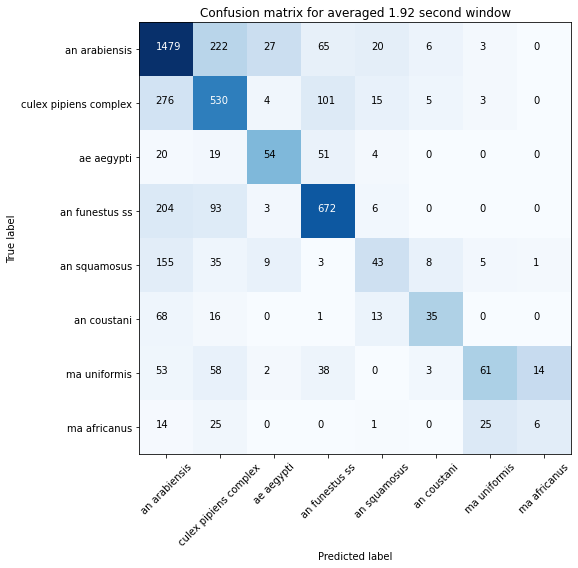

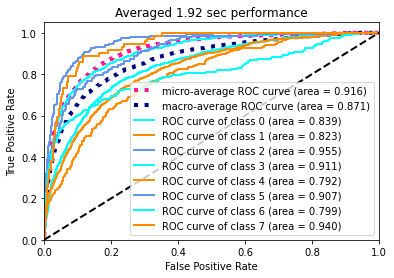

In [13]:
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(yt, y)
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for averaged 1.92 second window', classes)
print(classification_report(yt, y))
compute_plot_roc_multiclass(yt,p, classes, title='Averaged 1.92 sec performance')

In [ ]:
# WAiting for this above

Evaluating on cuda:0


F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
F:\PostdocCode\HumBugDB\lib\PyTorch\runTorchMultiClass.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()


BNN sampled
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      3763
         1.0       0.50      0.74      0.60      1831
         2.0       0.72      0.73      0.73       306
         3.0       0.82      0.64      0.72      1686
         4.0       0.49      0.25      0.33       498
         5.0       0.32      0.42      0.36       291
         6.0       0.50      0.31      0.38       498
         7.0       0.18      0.21      0.19       209

    accuracy                           0.64      9082
   macro avg       0.54      0.50      0.51      9082
weighted avg       0.67      0.64      0.64      9082



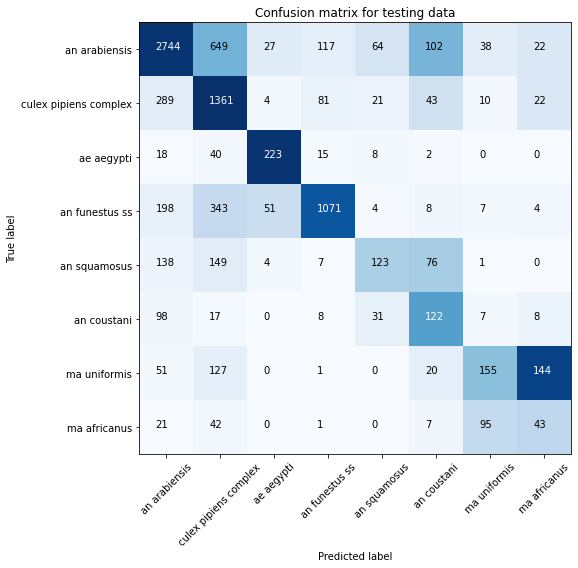

In [16]:
X_test_CNN, y_test_CNN = reshape_feat(X_test, y_test)
# 

preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, 100)

print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))

BNN
{0: 0.6811987791198945, 1: 0.8304175600630916, 2: 0.9788966938948171, 3: 0.9065493065726914, 4: 0.8959086579308848, 5: 0.907146523252264, 6: 0.897480181677315, 7: 0.9038360015896836, 'micro': 0.8628581699813198}


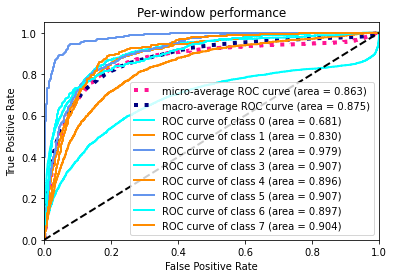

In [18]:
compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')

In [56]:
len(y_test_CNN)//64

151

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

def evaluate_model(model, X_test, y_test, n_samples):
    # Determine number of classes: warning potential issue if predicted classes dont match
    # number of classes in y_test
    n_classes = config_pytorch.n_classes 
                    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Evaluating on {device}')

#     x_test = torch.tensor(X_test).float()
    if model.n_channels == 3:
        x_test = x_test.repeat(1,3,1,1)

#     y_test = torch.tensor(y_test).float()
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    y_preds_all = np.zeros([n_samples, len(y_test), n_classes])
    model.eval() # Important to not leak info from batch norm layers and cause other issues

    for n in range(n_samples):
        all_y_pred = []
        all_y = []
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(x).squeeze()
            all_y.append(y.cpu().detach())

            all_y_pred.append(y_pred.cpu().detach())
#             print(np.shape(y_pred.cpu().detach()))
            del x
            del y
            del y_pred
#         print('shape', np.shape(all_y_pred))
#         print(all_y_pred)
        all_y_pred = torch.cat(all_y_pred)
        all_y = torch.cat(all_y)

        y_preds_all[n] = np.array(all_y_pred)
       
        test_acc = accuracy_score(all_y.numpy(), np.argmax(all_y_pred.numpy(), axis=1))
        # print(test_acc)
    return y_preds_all

In [32]:
def evaluate_model(model, X_test, y_test, n_samples):
    # Determine number of classes: warning potential issue if predicted classes dont match
    # number of classes in y_test
    n_classes = len(np.unique(y_test)) 
                    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Evaluating on {device}')

    x_test = torch.tensor(X_test).float()
    if model.n_channels == 3:
        x_test = x_test.repeat(1,3,1,1)

    y_test = torch.tensor(y_test).float()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    y_preds_all = np.zeros([n_samples, len(y_test), n_classes])
    model.eval() # Important to not leak info from batch norm layers and cause other issues

    for n in range(n_samples):
        all_y_pred = []
        all_y = []
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(x).squeeze()
            all_y.append(y.cpu().detach())

            all_y_pred.append(y_pred.cpu().detach())

            del x
            del y
            del y_pred

        all_y_pred = torch.cat(all_y_pred)
        all_y = torch.cat(all_y)

        y_preds_all[n] = np.array(all_y_pred)
       
        test_acc = accuracy_score(all_y.numpy(), np.argmax(all_y_pred.numpy(), axis=1))
        print(test_acc)
    return y_preds_all

BNN
{0: 0.6396588636640475, 1: 0.6817623240344572, 2: 0.9684962312080956, 3: 0.6660360860225648, 4: 0.8776850405189919, 5: 0.8983609490806201, 6: 0.8818786892144811, 7: 0.8656031089062338, 'micro': 0.8075211729299756}


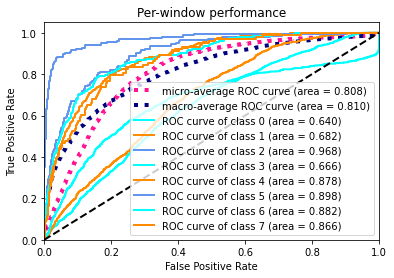

In [10]:
compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')

In [9]:
preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, 3)

Evaluating on cuda:0


In [ ]:
# Good morning me, random seed 10 on Keras here!

In [ ]:
print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))

In [ ]:
import sklearn
from evaluate import to_categorical
# debug multi ROC:

y_pred_prob = np.mean(preds_list,axis=0)
y_true = y_test_CNN

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], thresholds = sklearn.metrics.roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    

fig, axes = plt.subplots(4,2, figsize=(10,10))
for species_idx, ax in enumerate(axes.ravel()):
    ax.plot(to_categorical(y_true)[:,species_idx],'.',label='Target')
    ax.plot(y_pred_prob[:,species_idx], label='Prediction',lw=1)
    ax.set_title('Class: ' + classes[species_idx] + ' ROC: ' + '{:.2f}'.format(roc_auc[species_idx]))
    ax.legend()
plt.tight_layout()

NameError: name 'y_test_CNN' is not defined

In [ ]:
filepath

In [20]:
random_seed

42

In [16]:
# For now we can just save a copy paste of results, but let's write a func to store results for random seed

# Random seed 42:
#Keras filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'
#% Results: model_e91_2021_07_30_05_40_54.pth ResNet50, N=100 samples.
#% model_e96_2021_07_30_21_07_26.pth ResNet18, N=100

# model = Win_30_Stride_5_2021_08_18_14_10_40-e80accuracy0.9524.hdf5
keras_42_vggish = {0: 0.8413341217048536, 1: 0.8042731678837424, 2: 0.9501691460410684, 3: 0.9258843037321745, 4: 0.8092579197350647, 5: 0.9134437955649396, 6: 0.866946066883948, 7: 0.9388043349633345, 'micro': 0.9180642995084345}

# BNN
{0: 0.8372984498898841, 1: 0.8058505429532529, 2: 0.9175742360424536, 3: 0.9227520314727383, 4: 0.835822450249705, 5: 0.8988509549010585, 6: 0.8310132399992929, 7: 0.9181642637824974, 'micro': 0.9140538964306139}
# VGGish, Ivan broken features, /255 + dropout 0.2, batch 128filepath = '../outputs/models/pytorch/model_e39_2021_08_06_01_12_40.pth'

# Fixed features, aggregated 1.92 sec,  /255 + dropout 0.2, batch 128, 16khz
#e36_2021_08_06_13_14_00.pth
vggish_42 = {0: 0.8904729243656074, 1: 0.8604923505404996, 2: 0.9469179924059075, 3: 0.957138847848475, 4: 0.8880029630920737, 5: 0.9267071590872537, 6: 0.873972753772844, 7: 0.973498165771502, 'micro': 0.942025041919496}

# model_e26_2021_08_06_14_37_16.pth
vggish_42_no_255 = {0: 0.8726072431633407, 1: 0.8178592076911456, 2: 0.9592799057730161, 3: 0.9497177636275616, 4: 0.8442075907446948, 5: 0.9226569422471246, 6: 0.8316916217582583, 7: 0.9275164813351504, 'micro': 0.9276311835379564}


# VGG feats, 0.05 last layer, 0.2 throughout, fixed loss, batch 32
# '../outputs/models/pytorch/model_e97_2021_08_17_03_47_25.pth'
resnet_50_42_vggish = {0: 0.749260014781966, 1: 0.8730887709864616, 2: 0.9785501844740607, 3: 0.9566200331873831, 4: 0.9177036036428603, 5: 0.9523068689923001, 6: 0.8881780631837103, 7: 0.9575398052396712, 'micro': 0.9068805213596176}
#model_e90_2021_08_17_13_16_16.pth ResNet18
resnet_18_42_vggish = {0: 0.7894961320522296, 1: 0.873975026948315, 2: 0.9776990760162209, 3: 0.8564047280950408, 4: 0.908926750620942, 5: 0.9258152340791387, 6: 0.878187959168307, 7: 0.9421158713253399, 'micro': 0.9093801665683626}
########################################################################################################################################
# Random seed 21:
resnet_18_21 = {0: 0.907429826653944, 1: 0.9018660114354919, 2: 0.9772856383871792, 3: 0.975732819039722, 4: 0.9157321333198608, 5: 0.9043455991405537, 6: 0.8711321300741771, 7: 0.8655805677916948, 'micro': 0.9490051251978446}
# pytorch/model_e78_2021_07_31_02_00_40.pth

resnet_50_21 = {0: 0.8208432729007634, 1: 0.8115046638640783, 2: 0.9757929671957332, 3: 0.7947146706941483, 4: 0.8562466619512968, 5: 0.8373920938545786, 6: 0.6791755511030099, 7: 0.8306014955087708, 'micro': 0.8778591332615912}
#filepath = '../outputs/models/pytorch/model_e14_2021_08_03_11_51_30.pth'

# Keras Win_30_Stride_5_2021_07_31_02_31_05-e77accuracy0.9633.hdf5
keras_21 = {0: 0.8502981870229007, 1: 0.849051739196255, 2: 0.9469929230365854, 3: 0.9322344132512044, 4: 0.8140991959813502, 5: 0.8432175996349256, 6: 0.7260914040189472, 7: 0.8877960840870969, 'micro': 0.9110295743205659}

# Model: 
keras_21_vggish = {0: 0.8170196545917313, 1: 0.8111127416538446, 2: 0.9478667534616005, 3: 0.9136300805949962, 4: 0.7804814353611148, 5: 0.8663349471041779, 6: 0.734788777624092, 7: 0.8872927691382305, 'micro': 0.8996471720725929}


# model_e97_2021_08_17_15_08_51.pth
resnet_18_21_vggish ={0: 0.7167862256812063, 1: 0.8519269556383675, 2: 0.9848859348156994, 3: 0.9365691778496981, 4: 0.8390709792443033, 5: 0.891654499346807, 6: 0.8156109570754827, 7: 0.9103711738745496, 'micro': 0.8957420794204423}

# resnet_18_21_vggish_batch_128_run_to_test../outputs/models/pytorch/model_e97_2021_08_18_13_26_57.pth'
# {0: 0.8124654714266208, 1: 0.7995388528687177, 2: 0.9552745052933491, 3: 0.9137935439533938, 4: 0.7639761304127398, 5: 0.8731012577166423, 6: 0.714520790612059, 7: 0.9036465197380426, 'micro': 0.899290494010628}

# model_e95_2021_08_17_17_46_53.pth
resnet_50_21_vggish = {0: 0.7562153182580444, 1: 0.8661583820272685, 2: 0.9917748748244115, 3: 0.9624109880747354, 4: 0.8284534241308905, 5: 0.918563487794257, 6: 0.7617805772383149, 7: 0.9327196664030871, 'micro': 0.8977398423391644}
########################################################################################################################################
# Random seed 5 (extremeeeeeely high??):
# ResNet18: /model_e77_2021_07_31_20_01_44.pth'
resnet_18_5 = {0: 0.9229526271868468, 1: 0.9368816597520596, 2: 0.963522226188537, 3: 0.9485264392064245, 4: 0.9683964598097428, 5: 0.9573003617307201, 6: 0.9424164608703435, 7: 0.9598949535472974, 'micro': 0.9633259373270477}
# keras: Win_30_Stride_5_2021_07_31_03_25_35-e69accuracy0.9608.hdf5'
keras_5 = {0: 0.8651004342867288, 1: 0.8811829533956251, 2: 0.9773862293400246, 3: 0.9034032187347225, 4: 0.8367226904169062, 5: 0.9099093024039921, 6: 0.8506791500190954, 7: 0.9154296875, 'micro': 0.9292624736481938}
# Fixed features, aggregated 1.92 sec,  no /255 + dropout 0.2, batch 128, 16khz: model_e16_2021_08_06_16_02_47.pth
vggish_5_no_255 = {0: 0.8658949522686549, 1: 0.8370088097682757, 2: 0.9814101612743643, 3: 0.9516533399656568, 4: 0.8605287658304532, 5: 0.9407993370378521, 6: 0.8514515413743305, 7: 0.8881449344996679, 'micro': 0.9322349123541503}

#ResNet18 (dropout 0.2 everywhere), possibly just needs longer training...
#filepath = '../outputs/models/pytorch/model_e98_2021_08_02_15_00_40.pth'
# {0: 0.8550957508550351, 1: 0.849406683341789, 2: 0.9878116685901368, 3: 0.8979362164388284, 4: 0.829748850794867, 5: 0.9049481487190109, 6: 0.8161319506655927, 7: 0.7439875422297298, 'micro': 0.9176793014248503}

#model:  '../outputs/models/pytorch/model_e90_2021_08_07_00_03_43.pth'
resnet_18_5_vggish = {0: 0.8632565572156551, 1: 0.8606993660112701, 2: 0.984054368259622, 3: 0.9262450871907294, 4: 0.8874567970513589, 5: 0.9321736080545774, 6: 0.9390462544963858, 7: 0.8312083998699886, 'micro': 0.9312489580680509}
#model: Win_30_Stride_5_2021_08_18_14_43_54-e80accuracy0.9556.hdf5
keras_5_vggish = {0: 0.8397029610387242, 1: 0.828066240487924, 2: 0.9570000989413278, 3: 0.9154640864148073, 4: 0.7821108971334073, 5: 0.9250728983274648, 6: 0.8724542591055366, 7: 0.922532962141232, 'micro': 0.9190408600158666}

# 0.05 dropout everywhere
#filepath = 'model_e61_2021_08_02_17_29_50.pth'
# {0: 0.8517884463301456, 1: 0.851428843445032, 2: 0.9763095481520246, 3: 0.9045281929952107, 4: 0.8478659899125327, 5: 0.9192744834539904, 6: 0.817371602145421, 7: 0.8095663534628378, 'micro': 0.9137075568633347}
resnet_18_5_vggish_0_05 ={0: 0.8719454713950233, 1: 0.8589013819196331, 2: 0.988331107153458, 3: 0.947730539020253, 4: 0.8835796911068882, 5: 0.9114199356294013, 6: 0.910403945069232, 7: 0.9046309512033124, 'micro': 0.9390511565549353}


# ResNet 50, dropout full:
#model_e71_2021_08_01_04_23_48.pth'
# Poor training: {0: 0.8332316233468624, 1: 0.7640107082102523, 2: 0.959236873327072, 3: 0.8714290717106304, 4: 0.8300273734278235, 5: 0.7736509756132806, 6: 0.8295829224052605, 7: 0.7226958403716216, 'micro': 0.8824963879596882}
# ResNet 50, dropout last layer
# (run 1, collapsed after this epoch)
#filepath = '../outputs/models/pytorch/model_e73_2021_08_01_18_19_10.pth'
resnet_50_5 = {0: 0.84578597629865, 1: 0.8407899204043909, 2: 0.928063949317428, 3: 0.8699658067218299, 4: 0.8382569590755282, 5: 0.8560398433624098, 6: 0.800616813005796, 7: 0.7546056798986488, 'micro': 0.9056548177487792}
#ResNet50 without collapse:
#model_e91_2021_08_02_01_26_12.pth
#{0: 0.817411216577308, 1: 0.8262646263379168, 2: 0.9617859044872884, 3: 0.8675373975847583, 4: 0.80610475324012, 5: 0.8663555108141912, 6: 0.7648729379385633, 7: 0.6695101351351351, 'micro': 0.8957878697333836}

# vggish 16k feats batch 128 lr 0.0003
resnet_50_5_vggish = {0: 0.8351542858619885, 1: 0.8418764564229015, 2: 0.9871895715840507, 3: 0.9553846176758372, 4: 0.896955706615312, 5: 0.9490107146786974, 6: 0.9012737706720035, 7: 0.8732727555360853, 'micro': 0.9325309597774477}
#model_e94_2021_08_06_21_37_05.pth

########################################################################################################################################
# Random seed 10:
#Keras: filepath = '../outputs/models/keras/Win_30_Stride_5_2021_08_03_09_42_31-e60accuracy0.9614.hdf5
keras_10 = {0: 0.868455920254975, 1: 0.8615702636961775, 2: 0.9730785705361976, 3: 0.9308562976176432, 4: 0.851296768808193, 5: 0.9104649063525007, 6: 0.8836303162526624, 7: 0.9001826570333948, 'micro': 0.9318593580434757}

#Win_30_Stride_5_2021_08_18_15_04_54-e72accuracy0.9536.hdf5
keras_10_vggish = {0: 0.8473696722228438, 1: 0.8035617272196101, 2: 0.9325747304332255, 3: 0.9152017960078916, 4: 0.7710044054222164, 5: 0.9239096221483215, 6: 0.8751913707355821, 7: 0.9030988245023331, 'micro': 0.9159845328288768}
#ResNet18 fixed loss 0.05 dropout
filepath = '../outputs/models/pytorch/model_e28_2021_08_02_20_16_25.pth'
resnet_18_10 = {0: 0.7840781397344898, 1: 0.8421399387425842, 2: 0.9569429654175418, 3: 0.8797721353575868, 4: 0.853519557413038, 5: 0.9015866473028914, 6: 0.8547976861542096, 7: 0.9095814714112069, 'micro': 0.8957285991184005}

# dropout 0.2 everywhere, 0.05 last layer (maybe), fixed loss with "Other" feats: batch 32
#'../outputs/models/pytorch/model_e35_2021_08_16_15_48_41.pth'
resnet_50_10 = {0: 0.6525429334546577, 1: 0.8432583427906882, 2: 0.9850586884485188, 3: 0.9326164570204788, 4: 0.8914036066782197, 5: 0.8994361818213772, 6: 0.8782776098135412, 7: 0.8643831973113588, 'micro': 0.8621975165859281}

#model_e99_2021_08_16_21_43_19.pth VGG feats, 0.05 last layer, 0.2 throughout, fixed loss, batch 32
# Aggregated 1.92, no /255
resnet_50_10_vggish = {0: 0.6646994156978495, 1: 0.8562448223612148, 2: 0.9900391399444879, 3: 0.9268343087656646, 4: 0.9215947936853902, 5: 0.9328273186352999, 6: 0.9154275422078086, 7: 0.9351550593655857, 'micro': 0.866380036572024}

# '../outputs/models/pytorch/model_e97_2021_08_16_23_26_37.pth'
resnet_18_10_vggish = {0: 0.7458139354772089, 1: 0.8528744948496226, 2: 0.9803676724523861, 3: 0.7663236809619858, 4: 0.8649051831822878, 5: 0.9511930177498598, 6: 0.8891785098126515, 7: 0.8720562348632523, 'micro': 0.8939362170830951}

# Fixed features, aggregated 1.92 sec,  /255 + dropout 0.2, batch 128, 16khz
vggish_10 = {0:0.890, 1:0.871, 2:0.974, 3:0.950, 4:0.883, 5:0.952, 6:0.919, 7:0.928, 'micro':0.943}
########################################################################################################################################
# Keras: # random seed 100
#filepath = '../outputs/models/keras/Win_30_Stride_5_2021_07_31_13_20_53-e68accuracy0.9601.hdf5'
keras_100 = {0: 0.8783979335446752, 1: 0.8606896208591721, 2: 0.9723285337141679, 3: 0.9163527200878863, 4: 0.8784291728885104, 5: 0.8653711484593838, 6: 0.7928047235881388, 7: 0.9454135230293885, 'micro': 0.9291024226844671}

#model: 
#Win_30_Stride_5_2021_08_18_18_31_04-e80accuracy0.9527.hdf5
keras_100_vggish = {0: 0.8389078973400046, 1: 0.823353413182107, 2: 0.9547407212906535, 3: 0.910908735222731, 4: 0.7918171772169456, 5: 0.9072111713645744, 6: 0.7991306576348862, 7: 0.9395864415898009, 'micro': 0.9164868537136536}

# PyTorch ResNet18: model_e99_2021_07_31_16_58_14.pth
resnet_18_100 = {0: 0.8471517200892333, 1: 0.8359428490084403, 2: 0.9607714223098839, 3: 0.9048423292005864, 4: 0.8631383864390335, 5: 0.8048531339141162, 6: 0.840628259573834, 7: 0.8854465761299131, 'micro': 0.9143897312093303}




#resnet18_100_vggish_model_e94_2021_08_17_22_53_57.pth'
resnet_18_100_vggish = {0: 0.6618581357057157, 1: 0.8095909711273737, 2: 0.9841202476765062, 3: 0.7924360969129527, 4: 0.8327885574699015, 5: 0.9106598967583335, 6: 0.8526972226270221, 7: 0.9406154895171608, 'micro': 0.8762340668507328}


#resnet50_100_vggish model_e98_2021_08_18_01_51_12.pth
resnet_50_100_vggish = {0: 0.6811987791198945, 1: 0.8304175600630916, 2: 0.9788966938948171, 3: 0.9065493065726914, 4: 0.8959086579308848, 5: 0.907146523252264, 6: 0.897480181677315, 7: 0.9038360015896836, 'micro': 0.8628581699813198}

# PyTorch ResNet50 0 dropout module, but 0.2 on last layer:
# model_e85_2021_08_02_07_17_14.pth
resnet_50_100 = {0: 0.8713980979218034, 1: 0.8770412006241388, 2: 0.9334606168533831, 3: 0.8957214466894431, 4: 0.8724145133402227, 5: 0.7778289067920746, 6: 0.8119500633288631, 7: 0.8704534023137172, 'micro': 0.9191073388359018}



In [22]:
# Additions from Ben (GDrive) # dropout outer 0.05, 30 samples from averaged 1.92 sec perf, no 255, batch 32 lr 0.0003

#../outputs/models/pytorch/model_e033_2021_08_17_11_40_29.pth
vggish_21 = {0: 0.818, 1: 0.795, 2: 0.957, 3: 0.924, 4: 0.794, 5: 0.822, 6: 0.825, 7: 0.932, 'micro': 0.902}

vggish_100 = {0: 0.819, 1: 0.811, 2: 0.970, 3: 0.900, 4: 0.888, 5: 0.860, 6: 0.757, 7: 0.946, 'micro': 0.913}

# Other entries from GDrive also

In [24]:
resnet_18_42 = {0: 0.846, 1: 0.843, 2: 0.937, 3: 0.928, 4: 0.825, 5: 0.762, 6: 0.796, 7: 0.833, 'micro':0.910} # from paper
keras_42 = {0: 0.865, 1: 0.881, 2: 0.959, 3: 0.935, 4: 0.874, 5: 0.886, 6: 0.849, 7: 0.934, 'micro':0.933}
resnet_50_42 = {0: 0.841, 1: 0.849, 2: 0.933, 3: 0.919, 4: 0.847, 5: 0.811, 6: 0.837, 7: 0.869, 'micro':0.913}

In [25]:
df_vggish = pd.DataFrame([vggish_42_no_255, vggish_5_no_255, vggish_10, vggish_21, vggish_100])

In [26]:
pd.DataFrame([df_vggish.mean(), df_vggish.std()]) # Missing 10: no 255, 100 (either)

,0,1,2,3,4,5,6,7,micro
0,0.85310,0.826374,0.968338,0.935074,0.853947,0.899491,0.836829,0.924332,0.923573
1,0.03279,0.029145,0.010202,0.022721,0.037867,0.056046,0.058105,0.021572,0.016172


In [27]:
import pandas as pd

df_50_vggish = pd.DataFrame([resnet_50_5_vggish, resnet_50_10_vggish, resnet_50_42_vggish, resnet_50_100_vggish, resnet_50_21_vggish])
df_18_vggish = pd.DataFrame([resnet_18_5_vggish, resnet_18_10_vggish, resnet_18_42_vggish, resnet_18_21_vggish, resnet_18_100_vggish])

df_keras_vggish =  pd.DataFrame([keras_42_vggish, keras_21_vggish, keras_5_vggish, keras_10_vggish, keras_100_vggish])

df_50 = pd.DataFrame([resnet_50_42, resnet_50_21, resnet_50_5, resnet_50_10, resnet_50_100])
# df_50 = pd.DataFrame([resnet_50_42, resnet_50_5, resnet_50_10])
df_18 = pd.DataFrame([resnet_18_42, resnet_18_21, resnet_18_5, resnet_18_10, resnet_18_100])
# df_18 = pd.DataFrame([resnet_18_42, resnet_18_5, resnet_18_10])
df_keras = pd.DataFrame([keras_42, keras_21, keras_5, keras_10, keras_100])
# df_keras = pd.DataFrame([keras_42, keras_5, keras_10])

In [28]:
dataframes = [df_keras, df_keras_vggish, df_18, df_50, df_18_vggish, df_50_vggish, df_vggish]
df_names = ['keras', 'keras_vgg', 'resnet18', 'resnet50', 'resnet18_vggish', 'resnet50_vggish','df_vggish']
for idx, dataframe in enumerate(dataframes):
    print(df_names[idx])
    print(pd.DataFrame([dataframe.mean(), dataframe.std()]))


keras
          0         1         2         3         4         5         6  \
0  0.865450  0.866699  0.965757  0.923569  0.850910  0.882993  0.820441   
1  0.010082  0.014037  0.012548  0.013394  0.026678  0.029073  0.062025   

          7     micro  
0  0.916564  0.926851  
1  0.023630  0.009001  
keras_vgg
          0         1         2         3         4         5         6  \
0  0.836867  0.814073  0.948470  0.916218  0.786934  0.907194  0.829702   
1  0.011580  0.011149  0.009592  0.005699  0.014499  0.024019  0.061699   

          7     micro  
0  0.918263  0.913845  
1  0.022825  0.008030  
resnet18
          0         1         2         3         4         5         6  \
0  0.861522  0.871966  0.959104  0.927375  0.885157  0.866017  0.860995   
1  0.055512  0.045095  0.014544  0.037283  0.056939  0.080043  0.053408   

          7    micro  
0  0.890701  0.92649  
1  0.047782  0.02841  
resnet50
          0         1         2         3         4         5         6  \


## Evaluate mean + std over xval splits

In [ ]:
# Supported for both Keras and PyTorch but requires separate kernel instances.
results_dict = {}

def evaluate_xval(filepaths, X_test_CNN, y_test_CNN, N_samples)
    for filepath in filepaths:
        model = load_model(filepath)
        preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, N_samples)
        roc = compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')
        cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
        results_dict[filepath] = [cnf_matrix, roc]
    return results_dict
    


# Evaluate performance per recording (extension)

In [66]:
import feat_vggish
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, y_item = feat_vggish.reshape_feat([recording], [y_test[idx]])
        preds_list = evaluate_model(model, X_item, y_item, BNN_samples)
        preds_values = np.mean(preds_list,axis=0)
        print(preds_values)
        print('shape', np.shape(preds_values))
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

In [ ]:
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, _ = feat_util.reshape_feat([recording], [y_test[idx]], config.win_size, config.step_size)
        for i in range(BNN_samples):
            preds_values = model.predict(X_item)
            preds_list.append(preds_values)
        preds_values = np.mean(preds_list,axis=0)
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

In [67]:
preds_aggregated_by_mean, y_aggregated_prediction_by_mean = evaluate_aggregate_predictions(X_test, y_test, model, 2)

Evaluating on cuda:0
0.896551724137931
0.896551724137931
[[ 10.14621592  -6.71275854 -15.28148794 -10.87760925  -6.29519701
   -7.91364884  -3.84272385  -7.79904556]
 [  8.85521412   0.63248618 -11.15792274  -6.03582263  -3.35951704
  -18.49237823  -7.2160418   -9.82138824]
 [ 11.42173719  -9.09750342 -17.00913    -12.96018553  -5.96361136
   -9.58584237  -1.67839146  -8.37996936]
 [  6.42129087  -3.40634    -13.87028551  -6.31485534   3.24298012
   -3.55902469 -12.49643946 -12.23573923]
 [  7.44901419  -3.4512471  -16.28270197  -7.98087335  -3.60529459
   -4.83553028  -6.53632593  -5.62160552]
 [ 11.45974112  -7.08099699 -15.7505722  -19.61388493  -9.61651754
  -13.52597237   3.98088503  -5.72681141]
 [  8.39200592  -7.05726147 -12.40532827  -8.69774103  -2.98824966
   -6.85305381  -3.84307873  -7.20569825]
 [ 12.20151281  -7.381634   -18.69508934  -7.7782228   -8.68278027
  -12.35432529  -9.67861462  -9.02125168]
 [ 11.70303535  -8.90476036 -19.30962372  -6.53759444   6.11346078
  -1

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.9
[[  1.37803483  14.2173543   -6.43950057  -5.87062001  -9.57992101
  -28.5388298   -8.95145345 -17.2793088 ]
 [  6.1774013    5.07271433  -9.82012939 -11.82141113  -5.16497886
  -21.9366684   -3.1582253  -12.73712969]
 [ 14.01260281  -4.7650367  -22.90634918  -4.85907447 -11.40567636
  -18.79489231 -11.43673897 -14.45088243]
 [  9.52878141  -3.53590989 -12.45217705   0.12175679  -3.58164895
  -18.10603523 -12.0973568  -15.89446545]
 [  8.62466669   3.63298607 -11.67256975   1.65194282 -10.52531147
  -22.27604198 -12.11858177 -13.6942215 ]
 [ 18.36463261  -8.30750704 -25.15816498 -13.87496758  -4.37882757
  -21.4508667  -10.25696421 -20.46936417]
 [  9.9983449   -5.28254652 -18.6430645  -12.71898127  -2.26271361
  -12.83580828  -2.78300428 -11.63106394]
 [ 12.52728653  -5.76153374 -15.22955227  -9.01589441  -8.54310417
  -15.89120293  -5.39791369 -11.32190275]
 [  9.361938    -5.73474956 -15.06002712  -8.38844466  -1.15741789
   -8.70562649 -10.55403519 -13.71486378]
 [ 18.03778553 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.5714285714285714
0.7142857142857143
[[  8.21894169  -4.18536079 -16.60918999  -7.68140149   4.81361628
   -9.23427868 -12.75992107 -15.74491405]
 [ 11.85013819   0.73319939 -16.39079952 -10.44728661  -4.35202789
  -20.5301075  -10.24127841 -13.11757803]
 [  2.26863939   3.91985321  -6.79933167  -0.77233674   0.59040255
  -15.30028582 -12.6827054  -13.2433815 ]
 [  5.59711528   0.94449942 -12.96945763  -0.41881378   4.90084338
  -16.83733177 -14.08797646 -17.72324848]
 [  6.51046848  -6.49609661 -21.16530609  -9.22407079   2.49893813
   -3.2617321   -6.25670838  -9.69818735]
 [  2.79193342   3.01702619  -0.12024379 -12.08057642  -5.40935707
  -17.4838047   -1.15787661 -10.23853302]
 [  1.41898543   1.52585024  -4.13316619  -0.97004798   4.81235671
  -12.62355423 -13.85870028 -15.08502293]]
shape (7, 8)
Evaluating on cuda:0
1.0
1.0
[[  8.95683813  -8.96167135 -18.65255165  -7.3616457    1.83699894
   -8.57983494  -7.39813805 -13.48033953]
 [  7.35025597  -1.7309053

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
1.0
[[  6.60143447  -2.71057737  -8.47763062  -3.28349292  -5.39602625
   -8.21418715  -5.51528895  -7.34247899]
 [ 15.52609015  -2.55930246 -13.36764479 -10.19912815  -8.09216881
  -21.15188122 -10.41461754 -15.51774931]
 [ 13.6587286   -0.80229604 -12.98262024  -3.21987391 -10.4812994
  -21.06373882 -15.10017014 -16.22564602]
 [  9.66614723  -0.4102848   -6.27930188   4.63437319 -11.9272871
  -21.96089554 -13.89646626 -14.30165386]
 [ 12.23255062  -7.41226912 -17.68741465  -8.46565104  -4.28177726
  -11.46676064  -8.22936702 -13.44719076]
 [  9.73291588   2.32496309  -9.83922434  -5.33994031  -6.3255105
  -15.37304401 -11.31063271 -11.31665993]
 [ 13.80110502  -2.20532979 -13.36023045 -12.12432289  -7.08803654
  -18.04833031  -7.77731776 -12.14500666]
 [ 10.03791475  -2.20423317 -12.41207743   3.24481273 -11.53272009
  -18.77358055 -13.62103033 -12.18362045]
 [ 10.29760838  -4.60505295 -12.92529297  -5.87573671  -9.39250445
  -11.67071867  -5.81740737  -7.95060062]
 [  6.98187494

<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ 17.37870598 -10.16620541 -23.85215092 -20.60443592  -2.01503509
  -12.75225639  -7.83355331 -17.05131149]
 [ 13.49182081  -4.82650328 -17.69175148 -13.19492865  -2.65476757
  -13.10607672  -9.01942921 -11.3589015 ]
 [ 15.59322071  -7.10973334 -19.67981339 -13.36343718  -7.26174402
  -14.97132397  -7.61244273 -14.36956024]
 [ 14.78102493  -7.71300745 -16.9220767  -16.95300961  -4.57724738
  -12.11605501  -6.80976105 -14.51559401]
 [ 13.04189587  -4.512842   -17.98644495 -13.92746449   1.07256968
  -16.52725935 -10.52229881 -17.09286499]
 [ 15.89630842 -11.07167149 -18.94048882 -15.4701252   -1.83170967
  -10.71619797 -12.93498421 -18.73386288]
 [ 12.69106388  -9.35189056 -19.4819088  -10.06298923  -3.82656384
   -6.23305988  -6.07105231 -12.70672798]
 [ 14.84121037 -10.00822592 -17.84697533 -13.9639864   -5.13051033
  -12.59065819  -5.7590524  -15.31479216]
 [ 11.38392019  -4.75539505 -14.13866186  -6.89347529  -7.48223639
  -10.59291124  -9.52311611  -9.73705983]
 [ 12.26228285 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ 7.19983268e+00  4.78764005e-01 -7.82650304e+00 -8.66565138e-01
  -8.60165930e+00 -1.24390588e+01 -8.25847411e+00 -5.25988054e+00]
 [ 6.90155292e+00 -4.57931483e+00 -3.32752156e+00 -1.31280199e-02
  -9.04621363e+00 -1.42770829e+01 -9.42558956e+00 -8.19714451e+00]]
shape (2, 8)
Evaluating on cuda:0
0.42857142857142855
0.5714285714285714
[[  4.04096627   1.17927788 -16.02512789 -12.0270052   -4.84644008
   -2.71190548  -7.14796901 -11.37182617]
 [  8.14812946  -4.71657181 -12.78935957  -9.1003089    2.92476237
   -8.56975675 -11.97837353 -15.59710503]
 [  6.80232239  -2.02798605 -10.59216118  -7.93173766   2.76331055
  -12.01331568 -13.10629272 -14.86279726]
 [  6.10734725   0.51084214 -19.39215422 -11.99601698   9.69737673
  -10.48470879 -16.82205582 -21.03699589]
 [  2.13811225  -2.03948843 -22.48671341 -11.80631828   1.1307382
    5.62576175 -11.6933217  -13.22829056]
 [ -0.94808108  -7.12518597 -11.82135677  -6.30738735   9.19268799
    4.01618516 -12.48816681 -13.39490509]
 [ 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.0
[[  5.04737186   5.92094398  -9.44096851 -14.15829754  -1.79199671
  -18.62786198  -7.68035483 -16.16507387]
 [ -6.39512706  18.28984976 -15.01462698 -11.26963091  -6.597996
  -20.70084     -7.59806609 -13.17342329]
 [ -6.13939261  21.31697273 -15.72738552 -14.5503521  -13.68144083
  -24.292243    -4.90554488  -8.82249045]
 [  1.55261889   6.46168661 -15.1390419  -13.66705322  -2.9162128
  -14.80837059   0.95041238 -11.00098896]
 [ -1.89948267   6.91006923 -12.42207479 -10.19475746   4.56759453
  -10.3569293   -5.62591553 -13.14729452]]
shape (5, 8)
Evaluating on cuda:0
0.5
0.5
[[ 10.98126364  -5.74934435  -9.87397575   0.37096165  -5.44713283
  -17.03207827 -15.25199175 -15.86435127]
 [  4.46344829  -2.83483231  -3.45734018   8.98170424  -7.17456174
  -13.61777115 -10.31462336  -7.55491567]]
shape (2, 8)
Evaluating on cuda:0
0.6
0.6
[[  9.28705168   1.18892871  -6.97936797   3.46589065  -7.67152596
  -20.81562805 -10.85575533 -11.13974476]
 [  8.95799208   3.95893025  -6.74464417 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  8.0237987    4.80314851 -18.12254381 -16.71217728  -6.17935991
  -19.95304775  -4.47536516 -12.41742611]
 [ 13.12566137  -4.40083873 -18.40280342 -12.88463974  -2.79698807
  -16.01436663 -10.56346512 -16.58133888]
 [  7.76377654  -2.56101584 -12.09557676  -2.62410212  -3.56683886
  -10.17190266  -9.4069376  -12.19291544]
 [  4.74960279   3.3193835   -2.97195661 -14.53516388  -1.11587703
  -20.65742016  -3.89050877 -14.28547049]
 [  6.11674547  -0.94984074  -1.55407217  -0.7875741   -5.86589289
  -15.78398609 -12.01379681 -11.78923512]]
shape (5, 8)
Evaluating on cuda:0
0.4
0.5333333333333333
[[  8.34526539   3.26828682  -5.95307899  -5.61025453 -12.98030281
  -20.16843033  -5.26795673  -9.54563761]
 [  5.42764354   5.72840905   0.38031587  -1.21471095 -15.64379883
  -20.98773003  -8.90888286  -6.3576088 ]
 [  4.22684097   6.90211701  -4.93643177  -9.34129286  -8.07116604
  -17.28478718  -6.14202404  -7.9005444 ]
 [  5.04287577  -1.45117795   7.47291565  -0.98463817  -7.77894115

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (50, 8)
Evaluating on cuda:0
0.3448275862068966
0.3448275862068966
[[  0.64740166  13.18145895 -12.9265275   -5.16810036  -7.69524574
  -19.73328972 -11.79673958 -14.86050606]
 [  6.44832468   1.30986129  -6.48082352   1.50525296  -7.11457539
  -14.36197329  -5.21544695  -7.32619071]
 [  9.02869177  -1.68919349  -5.46137452  -7.36547828  -6.72989058
  -13.96515799  -7.81787467  -9.79751968]
 [  1.45689458   9.47304487  -5.83683872  -8.71675253  -6.10832572
  -16.10794544  -6.33051348  -9.37615895]
 [  4.08135259   4.0742569   -5.1782279   -7.97825122  -5.2497046
  -11.65401983  -2.41931093  -6.27486444]
 [  0.97480962   6.62514257  -1.92530209   1.13093165  -6.45510077
  -13.98913145  -8.14826345  -8.21165156]
 [  0.50851161   2.01364356 -10.40283203  12.84289026  -9.27864647
  -15.84006977 -14.13225222  -8.78771973]
 [  3.57448602   5.03908038  -7.57551026  -3.41519606  -5.69954467
  -11.62227726  -5.63266706  -7.46415544]
 [  2.77436554   3.75499392  -8.77197075   2.21528375 -

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.9047619047619048
[[ 1.00737643e+01 -2.66863120e+00 -1.44412031e+01 -1.05753908e+01
  -5.85318637e+00 -1.70470791e+01 -5.00317383e+00 -1.49004602e+01]
 [ 1.10295477e+01  5.21837902e+00 -1.24603033e+01 -1.89851856e+01
  -1.31419420e+01 -3.02307396e+01  1.72585940e+00 -1.55599403e+01]
 [ 1.84606254e-01  1.22946963e+01 -1.33453746e+01 -1.64071608e+01
  -6.99169159e+00 -2.35332136e+01 -3.38475680e+00 -1.54525414e+01]
 [ 5.59522653e+00  7.32606077e+00 -7.08217144e+00 -8.04171896e+00
  -1.10227032e+01 -2.21766233e+01 -7.84170675e+00 -1.12470951e+01]
 [ 3.46000421e+00  1.31354771e+01 -8.64230180e+00 -1.34317260e+01
  -1.04917164e+01 -2.55577126e+01 -1.12689996e+01 -1.63027802e+01]
 [ 9.13557911e+00 -3.12516785e+00 -1.33266239e+01 -1.09190919e+00
  -2.05093580e+00 -1.51547885e+01 -1.19789515e+01 -1.45006638e+01]
 [ 1.61981106e+01 -8.95370531e+00 -2.00887632e+01 -9.34904242e+00
  -5.26586342e+00 -1.52114692e+01 -1.20058327e+01 -1.64462109e+01]
 [ 9.61353016e+00  3.39754477e-01 -1.36823263e+01 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.8387096774193549
[[ 1.02756786e+01 -9.17209673e+00 -1.86026163e+01 -1.07527537e+01
  -1.44197255e+00 -4.42347014e+00 -5.13327479e+00 -9.10327578e+00]
 [ 1.41058445e+01 -1.03852625e+01 -2.29997158e+01 -1.26521115e+01
   2.18889982e+00 -1.13795872e+01 -9.72083950e+00 -1.57359314e+01]
 [ 8.76003408e+00 -1.24009047e+01 -1.60203123e+01 -1.36096010e+01
  -7.93219018e+00 -5.30042458e+00  4.14184713e+00 -4.29371166e+00]
 [ 5.73188806e+00  1.39393668e+00 -1.32538800e+01 -1.29134035e+01
  -5.71594071e+00 -1.20867887e+01  1.49636756e+00 -6.39821529e+00]
 [ 7.45233035e+00 -3.92249155e+00 -1.49942670e+01 -8.17964363e+00
  -1.16342638e+00 -8.45250344e+00 -2.53432947e+00 -9.89437675e+00]
 [ 1.08054009e+00 -6.89397264e+00 -9.51077890e+00 -1.05147290e+01
  -8.95465231e+00 -3.31255770e+00  9.40086842e+00 -7.57944494e-01]
 [ 6.24410081e+00 -1.04310064e+01 -1.47478213e+01 -1.24458508e+01
  -7.17748642e+00  8.51690367e-01  1.44836253e+00  1.87720114e+00]
 [ 8.63562489e+00 -2.50549054e+00 -1.21866927e+01 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.6666666666666666
[[  4.70145845  -1.45348194  -4.15191567  -6.43812227  -8.60440826
   -9.53088951  -1.6735155   -5.38111711]
 [  1.01341712   3.18891323  -7.28652072  -4.75571859   2.22148162
   -9.08534527 -10.22134638 -10.12501717]
 [  5.36165953   0.31002946  -5.87615299   0.62447509  -2.65584254
  -13.98995066 -10.99912262 -11.31964874]
 [  2.54196149  -3.14681554  -9.20798159  -1.23305655   8.53551292
   -7.27452445 -17.40841866 -15.38134766]
 [  7.56870532  -3.28070962 -10.45397568  -8.74507713  -4.80030763
  -10.47927713  -7.64785886  -5.26997375]
 [  6.00421953  -3.24913847  -1.28966764  -4.56511843  -1.96935457
  -12.84646988  -9.98407221 -13.08229113]
 [  6.30346441  -4.22447348 -14.84977722  -6.42340016   5.71217203
   -7.58226299 -12.21001768 -15.3549757 ]
 [  1.7759178   -0.59195136  -1.80220705   0.54288232   2.91839397
  -15.03812122 -14.03288031 -13.34739685]
 [  0.04226012   0.19363704 -13.11631536  -4.76821589   5.97998333
   -3.76132238 -15.47197104 -13.23491669]


<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.3448275862068966
[[-1.83383054e+00  9.35821724e+00 -5.86156559e+00  7.23815843e-01
  -5.63943172e+00 -1.28022165e+01 -1.08700523e+01 -8.22228193e+00]
 [ 4.66748810e+00 -7.33035058e-02 -9.36849403e+00 -1.35838814e+01
  -5.03442919e+00 -1.55038834e+01  1.86737476e+00 -1.07860208e+01]
 [ 2.57403231e+00  9.47287846e+00 -6.76103687e+00 -5.20759940e+00
  -5.26326680e+00 -1.63942595e+01 -7.61259007e+00 -9.87457085e+00]
 [ 3.27966177e+00  5.28848386e+00 -6.67244244e+00  1.50379688e+00
  -5.40223503e+00 -1.25235643e+01 -9.86269855e+00 -7.31370139e+00]
 [ 2.92015088e+00  2.86466038e+00 -5.54698050e+00  5.34887767e+00
  -5.05076027e+00 -1.06204624e+01 -1.18133116e+01 -1.11982737e+01]
 [ 7.82016492e+00  1.23142430e+00 -5.59168434e+00  2.00522017e+00
  -5.46640968e+00 -1.47119331e+01 -1.41517949e+01 -1.42560010e+01]
 [ 5.59417939e+00  6.13244629e+00 -9.94560432e+00 -2.16679537e+00
  -2.02891718e+00 -1.59354768e+01 -1.44241529e+01 -1.71740971e+01]
 [ 3.49380827e+00  4.39910555e+00 -9.02163696e+00 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (58, 8)
Evaluating on cuda:0
0.2
0.4
[[  0.93480346   4.44728208  -8.53232098  -7.65567088  -5.62459707
  -12.05998421   1.96768475  -6.86933565]
 [  3.22493637   6.25045872 -10.04349709  -8.71438575  -4.67933798
  -16.09743214  -1.08116025 -10.30099773]
 [ -1.90030807   8.12183094 -13.75272989 -15.40866899  -9.45532703
  -16.79932928   3.50515366  -7.47954488]
 [  5.07205653   5.64993382 -17.91392756 -16.32445097  -7.09412837
  -15.37741852  -1.78311074 -12.03954887]
 [ 10.06694126   2.72509176 -10.10685062  -9.80205011  -9.43914127
  -19.21016502  -4.97331583 -10.01592731]]
shape (5, 8)
Evaluating on cuda:0
0.5
0.5
[[  9.29660487  -1.25978804 -13.35828209  -3.69318342  -5.86281884
  -13.64125586  -8.29085517 -12.10548735]
 [  2.65714872  -3.15841973  -9.7728467  -17.77607155  -3.6113019
  -14.90738153   8.02053785  -6.00118446]]
shape (2, 8)
Evaluating on cuda:0
1.0
0.5
[[  6.48064542  -3.07055044 -11.79498005 -15.28126478  -8.16912317
  -12.77166605   5.24054503  -6.89506269]

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  5.70969653  -9.92928171 -17.28514004  -8.29253531  -3.59087765
    2.5976243   -0.41804869  -6.67580605]
 [  7.3129673   -9.48502588 -15.6266489   -3.48182857  -4.45046818
   -1.38538623  -5.26772356  -5.90516114]]
shape (2, 8)
Evaluating on cuda:0
0.5
0.5
[[ 2.73774850e+00 -1.13175011e+01 -2.05387182e+01 -5.80992174e+00
  -3.56853008e-04  1.01558819e+01 -6.97476029e+00 -5.78783464e+00]
 [ 5.85730720e+00 -1.38803535e+01 -2.65909252e+01 -9.91611767e+00
   5.22648614e-01  1.37740855e+01 -1.10434208e+01 -8.11369991e+00]
 [ 1.81244320e+00 -4.81336427e+00 -2.36516285e+01 -1.27426310e+01
   9.01919514e-01  6.28797150e+00 -8.55741906e+00 -1.35121326e+01]
 [ 6.81919003e+00  4.14341187e+00 -1.02222824e+01 -3.19192219e+00
  -4.62000549e+00 -1.96294041e+01 -8.35171795e+00 -1.33114328e+01]
 [ 1.07226076e+01 -1.14934287e+01 -2.37664280e+01 -1.35093966e+01
  -2.57421410e+00 -1.00289965e+00 -7.53957891e+00 -1.23366680e+01]
 [-8.62053216e-01 -5.01603866e+00 -1.78934994e+01 -1.06752648e+01
  -4

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.29508196721311475
[[  4.36072671   4.60070491 -11.32981491  -1.95427144  -7.5103128
  -16.39519835  -9.2701273   -8.46836138]
 [  1.9385252    6.39727449  -2.28799129  -0.29578992 -11.41526222
  -19.95561123  -7.18755865  -9.29365778]
 [ -3.15415502   8.73092651   5.34598637  -7.22960544  -1.89029814
  -19.99196529 -11.11474705 -11.53030968]
 [  1.35763878  10.33178282  -1.54755291  -8.21886635 -12.31593704
  -22.07404804  -6.59223795  -6.80522394]
 [ -3.83940649   4.5276643   14.45222902  -6.96269941  -5.6951642
  -21.89032841 -14.89277363 -14.21282625]
 [ -1.64851493   1.87327909  10.47957945   2.96395659  -6.44696498
  -20.58424759 -14.86428928 -10.74010563]
 [ -3.04856002   0.48869205  17.73719788  -0.11369628  -4.15825999
  -21.82774544 -16.65649319 -14.91574287]
 [ -5.2188468    7.3252852   18.40717316  -6.67899311  -1.44291858
  -26.88013363 -22.7396574  -20.40007973]
 [ -1.16650072   6.58569479   3.20433277  -6.52994943  -0.6872419
  -17.45077133  -9.88209963 -14.28281975]
 [

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (37, 8)
Evaluating on cuda:0
0.6551724137931034
0.7586206896551724
[[  8.95174646   2.0519768  -15.13713741  -4.03785884  -4.97560203
  -17.03469276  -8.53375363 -12.56113386]
 [  8.91653442  -4.95782971 -16.83227968  -6.11157584  -6.42249846
   -6.40084171  -5.97997665  -7.67573214]
 [  0.40751631   2.23287797  -6.90512037   8.96868134  -4.99072957
  -14.4531436  -12.07771492 -11.44623232]
 [  3.7280035    4.54747438  -9.01368332   3.38863945  -5.32132363
  -16.15759945  -9.53741217 -10.55501175]
 [  9.73593903   1.27664436 -17.63468933  -7.01505542  -5.39298141
  -15.38134861 -10.93115091 -13.51651764]
 [  8.94434071  -0.99481329 -11.62484598  -5.16033733  -3.46206307
  -14.83064175  -6.82608461 -10.37621498]
 [  7.9625001   -2.15477443 -13.78904915  -8.79625034  -3.08942783
   -9.34670687  -7.63565373  -9.61423922]
 [  1.85227776   3.22198129 -11.26436138  -0.78185053  -5.88745332
   -7.79202437  -7.06954813  -7.5374701 ]
 [ 11.58420372  -9.82656574 -18.57736015 -11.69238806 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.967741935483871
[[ 10.28439426  -1.9341588  -21.196311     2.52930301  -6.15196729
  -16.90380096 -14.47118807 -15.4963479 ]
 [  9.97409391  -5.03008819 -17.31599617  -4.76667523  -5.47834063
  -10.8970356   -8.91233206 -11.26737165]
 [ 10.39148951  -4.21517611 -13.72230577  -2.14447132  -3.37881827
  -14.59602404  -9.66205597 -14.02445507]
 [  8.77400398   2.1603862  -10.47069883  -3.8861413   -6.50401306
  -20.75422573  -5.49737239 -10.67634964]
 [  8.67154646  -1.0828498  -14.18827438  -3.5614897   -3.57579672
  -13.89262056  -9.03433895 -12.98416567]
 [  6.19711471  -0.9565201  -13.99593639  -9.39088917  -3.6251415
  -11.99603176  -3.58838713 -16.76520872]
 [  3.3312664    0.30084884 -13.76464128   4.77731967  -9.44573116
  -14.94306374  -7.46166086 -11.73039627]
 [  8.03206539  -2.85720849 -18.38912868  -2.28114676   3.28124666
  -11.69288349 -12.74000835 -17.46963215]
 [  5.92455173  -4.76293755 -10.86528397   3.45670378  -4.94157588
   -9.10648918  -8.86202002  -9.75247192]
 [

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (53, 8)
Evaluating on cuda:0
0.0
0.5
[[ 11.95647383 -10.36856604 -13.98675728  10.79273748 -11.79001427
  -16.79285622 -20.52266312 -16.23519325]
 [  7.93544817  -9.87916565 -10.37912178  11.51148462 -11.02947474
  -15.51791763 -14.2128644  -14.34253788]]
shape (2, 8)
Evaluating on cuda:0
0.5
0.5
[[  9.6708498   -5.53779471 -17.4615283   -5.04372573   1.99501604
   -8.34612465 -13.15199757 -15.79819059]
 [  7.13078713  -5.56829572 -10.56308746  -7.20432329  -5.43466496
   -6.1779604   -1.35356927  -6.48754191]
 [  7.46776628  -6.38663673 -16.02249908  -8.26160145  -0.43301032
   -6.55153847  -4.82610393 -12.2857461 ]
 [ -1.49323261   2.61651385 -12.06901884  -3.75147331   8.06141424
  -10.04625034 -12.34839916 -17.62397766]
 [  2.2139681    6.11756968 -12.59678602  -5.20634007   0.40393814
  -13.10781145 -10.00372028 -13.43798828]
 [  1.39148587   6.94875145 -10.74019575  -0.95333752  -4.95034719
  -12.29434156  -9.26080465  -9.53523731]
 [  7.53543568  -3.47838044 -15.4575839  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (55, 8)
Evaluating on cuda:0
0.8529411764705882
0.8235294117647058
[[ 6.75470853e+00  3.43329990e+00 -1.42267375e+01 -9.71301377e-01
  -1.88657099e+00 -1.77576962e+01 -1.06606607e+01 -1.51543756e+01]
 [ 1.11596918e+01 -2.66968250e+00 -1.57033219e+01 -2.58512387e+00
  -9.19247913e+00 -1.63394070e+01 -1.04069381e+01 -1.46425133e+01]
 [ 9.55963612e+00  4.21433449e+00 -1.47566366e+01 -6.07174993e+00
  -9.76404238e+00 -1.94320917e+01 -9.83466029e+00 -1.29335055e+01]
 [ 3.98374677e-01  6.88858461e+00 -6.97049952e+00 -1.61176172e+00
  -6.70590377e+00 -1.22760191e+01 -5.91750407e+00 -6.09408164e+00]
 [ 6.88274479e+00  2.35247195e+00 -1.38237324e+01 -1.26414700e+01
  -1.65806785e-02 -1.63513498e+01 -8.93132901e+00 -1.48738232e+01]
 [ 1.30725698e+01  3.02034855e+00 -1.94963808e+01 -1.55322104e+01
  -9.01494098e+00 -2.34511147e+01 -7.37015891e+00 -1.63798094e+01]
 [ 1.15842576e+01  2.32601333e+00 -1.94889393e+01 -1.12477407e+01
  -7.44010973e+00 -2.06374569e+01 -8.59091949e+00 -1.44982066e

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (29, 8)
Evaluating on cuda:0
0.2222222222222222
0.2777777777777778
[[ -2.66789103   4.98408198  -8.74909687 -10.14196062   0.24415156
   -7.90031719   0.36442576 -11.66095686]
 [ -3.19755369   8.63739443 -12.1323576   -6.78164196  -2.58763349
   -9.93257713  -5.82781553 -11.90860939]
 [ -3.73709702   7.93082118 -11.18020678  -7.40143681   0.0543713
   -6.78873014  -7.41502476 -12.5085454 ]
 [ -0.4237703    8.47892284  -8.69460726  -5.68874216  -1.82579476
  -13.83875179  -3.80162561 -11.76144695]
 [  4.57169724   7.22538638  -9.50578308   3.01300442  -4.43984127
  -18.72581387 -13.4240613  -16.45629406]
 [  6.39315557   4.56243682 -11.90169764  -7.23768806   0.31807637
  -14.858356    -7.27551985 -17.2420702 ]
 [  1.52126557   4.88244772  -8.34045982  -7.65098739  -0.73413453
  -11.22466278  -3.39449549 -13.52705479]
 [ -0.82151082  -1.10636339 -15.58077335  -9.00303268  -1.92639428
    3.41514015  -2.69708884  -8.06641984]
 [  2.75031257  11.74637127  -9.70274973  -6.61956048  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (26, 8)
Evaluating on cuda:0
0.9117647058823529
0.9705882352941176
[[ 13.57708454  -5.02015018 -18.82362747 -11.43119526  -9.99605775
  -15.57645893  -4.49012887 -12.170609  ]
 [  3.91094196  -6.50453854 -15.07129526 -18.43334579  -4.8009932
  -12.6004324    9.33879614  -9.14039898]
 [  3.38269103  -3.04188824 -11.25362682 -13.7115097   -1.24461859
  -10.07150459   2.96854854  -9.58957052]
 [  6.74207115  -5.04852891 -18.08184433 -11.22098255   1.9188422
   -5.28128266  -2.52110767 -16.01051092]
 [  8.8974061  -12.61419916 -20.13410187 -12.46793509  -6.78559971
   -1.33180051   0.48442106  -4.36287236]
 [  8.46667099  -8.68873978 -17.47558022 -11.46604538  -3.70814478
   -3.36770499  -3.99841201 -10.83356524]
 [  1.78135473   0.76285085  -6.90701985   0.85356186  -4.46234107
   -7.45846963  -6.61368299  -6.80138779]
 [  9.35562706  -3.05981982 -20.15847683  -8.54312563  -4.03398621
   -7.38072395  -7.782269   -11.34157848]
 [ 14.56951952  -6.38006186 -20.73162842 -14.54023266  -

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.0
[[ -1.23610261  12.63683033  -9.23673964  -0.83014269 -10.97841167
  -16.93436909  -9.80683565  -7.35035396]
 [  2.47352231  11.08363342  -6.59445596   0.51516028 -13.10155535
  -21.27760124  -9.08767557  -5.39612103]]
shape (2, 8)
Evaluating on cuda:0
0.5405405405405406
0.6216216216216216
[[ 8.96845102e+00 -1.54184055e+00 -7.89646244e+00  4.49468362e+00
  -1.08100405e+01 -1.88569908e+01 -1.46675358e+01 -1.44656987e+01]
 [ 5.57017899e+00  6.23713422e+00 -5.77809930e+00  3.00670433e+00
  -7.65288210e+00 -1.95758209e+01 -1.34165478e+01 -1.20841370e+01]
 [ 7.55928063e+00  1.04601698e+01 -9.30019355e+00 -4.58010542e+00
  -1.06269603e+01 -2.69866886e+01 -9.87817049e+00 -1.28609757e+01]
 [ 1.08608117e+01  5.23253345e+00 -7.28687668e+00 -6.56487250e+00
  -9.10444331e+00 -2.36473055e+01 -1.04799466e+01 -1.59789934e+01]
 [ 5.91846347e+00  1.74948902e+01 -6.82350278e+00  7.72681877e-01
  -1.72293906e+01 -3.65536804e+01 -1.73175144e+01 -1.87436867e+01]
 [ 1.08638487e+01  4.71654022e+00 -7.465

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
1.0
1.0
[[ 14.19780445  -3.01231539 -14.70467377 -15.37604332  -3.32687318
  -18.78326607  -5.26309311 -16.89978313]
 [ 18.94108963 -16.14088964 -18.46024609 -18.77998114  -7.25779343
  -19.19863987  -4.08011985 -17.3079567 ]
 [ 14.31113148  -5.38898724 -16.30437851 -16.58305836   0.37557365
  -16.57626009 -14.6901474  -21.56650162]
 [ 17.1929636  -17.49089575 -26.36229801 -26.52495384  -3.73815924
   -5.73092031   0.21386588 -14.58924437]
 [ 12.12005329  -2.66742957 -14.10069656 -10.58558035  -5.93410778
  -11.22035551 -10.95608282 -15.30288124]
 [ 15.40413237 -13.50436306 -25.3741312  -18.28517437  -6.83272672
   -7.2017436   -3.15251124 -11.13284206]
 [ 14.40204144  -9.7680974  -20.17959976 -17.09158325  -5.63851881
   -5.54419231  -5.72347832 -13.0990591 ]]
shape (7, 8)
Evaluating on cuda:0
0.9705882352941176
0.9705882352941176
[[ 13.98278952 -11.45192719 -17.71741295  -7.20289469  -0.83679198
  -13.07969999 -13.27432823 -18.50077724]
 [ 14.14652681 -11.2765126

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.7435897435897436
[[  8.22662044  -8.52572632 -18.73080158  -6.17932272   8.90700293
   -7.51679468 -14.97973824 -17.68529034]
 [  6.75233293  -5.49708033 -13.04948425   5.68614936  -8.56787038
  -11.24816322  -9.34917545  -9.85503006]
 [  8.43431759  -8.70765877 -11.74758816  -5.60229385   5.38785076
  -11.3435359  -10.52287054 -16.38964272]
 [  6.53048062  -5.98569584 -12.74461365   4.98049021  -1.14108846
  -12.78611898 -12.76706362 -12.3498702 ]
 [  8.60650253  -8.10333848 -20.07696056  -1.61583361   5.53459263
   -8.42396331 -14.104774   -18.65069675]
 [  7.48651457  -8.28248501 -16.48473358  -3.86841619   0.87997252
   -1.43926394  -8.74171281 -10.05779457]
 [  8.58766413 -10.08611202 -16.22783422  -4.89724636   9.2448597
   -7.28834808 -16.39452744 -19.38696194]
 [  8.48054457 -10.2184844  -15.74518204   0.69653401  -4.0705086
   -6.27156973  -9.48139358 -11.3000083 ]
 [  9.38051414 -10.53201818 -17.204597    -4.23714614   0.32641935
   -5.38758564 -11.56792545 -13.09259129]
 [

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  6.47168684   1.8635447   -4.44085169   1.13276885  -7.34675431
  -17.01916695  -8.67113876  -9.3567543 ]
 [  9.33058214   0.663403   -12.10639954  -7.03337288  -1.61432093
  -16.95401669 -10.36642885 -16.78264999]]
shape (2, 8)
Evaluating on cuda:0
1.0
1.0
[[  8.21656823  -6.71645713 -14.14906263  -8.44626427   4.0927223
  -10.62456608 -13.32377052 -15.3936305 ]
 [ 12.10490656  -8.4349165  -17.06152534 -10.92606735   0.51851332
  -10.71305943 -13.10812283 -16.45283985]
 [ 10.41273022  -7.24183464 -10.17339897  -6.88735437  -2.74679106
  -11.56962872  -7.59235787 -11.84972191]
 [ 12.92093563  -7.95021629 -13.01698542  -9.93729973  -3.15784645
  -15.2810545   -7.10071743 -12.3950758 ]
 [ 13.0465765   -8.31593323 -13.71675014 -11.82085133  -3.20242012
  -11.28470516  -7.2447753  -10.82580185]
 [ 11.78310156  -3.50613666 -12.60612631  -6.65429568 -11.89020824
  -13.98748398  -7.98599839  -1.7524454 ]
 [ 13.12656212 -11.26022434  -7.61275351  -9.46820045  -5.69267023
  -17.57331562 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (31, 8)
Evaluating on cuda:0
1.0
1.0
[[ 14.91933966  -9.49629927 -15.70499659  -9.9503572   -3.71027005
  -17.79870081  -8.9781251  -20.13138771]
 [ 18.61036015  -8.32169056 -23.55930424 -17.31812859  -5.03371084
  -16.07042408 -11.90934801 -18.97290325]]
shape (2, 8)
Evaluating on cuda:0
0.9361702127659575
0.9361702127659575
[[ 12.7956996   -0.60967878 -20.70596695  -9.7924571   -5.4445647
  -16.80425358  -9.36715937 -15.47829056]
 [ 10.18213272  -2.02441382 -19.5051136   -4.1604203   -3.88512576
  -10.44570637 -12.98882818 -14.4740262 ]
 [ 10.78153181  -2.87548995 -19.55158234  -8.94126225   0.14509612
  -11.45695353 -12.60736704 -16.98795986]
 [  9.10696554  -5.4285183  -15.9724288   -7.45136046   1.04858268
   -8.66189957  -6.91861987 -13.27760267]
 [ 12.84188843  -9.20386457 -17.96592951  -9.97804785  -3.2514751
  -12.54476357 -10.14017534 -13.52204037]
 [ 13.12216091  -2.18908131 -22.42159557 -11.49640226  -2.93208146
  -14.72635555  -9.11437607 -18.34195232]
 [ 16.0682148

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ 15.47392321  -7.53723884 -23.15630722  -9.33007765  -4.54651892
  -16.65259552  -9.7203238  -14.60151815]
 [ 16.69318581  -8.4367919  -26.16916847 -12.32656097  -3.15241671
  -13.86487722 -11.58466864 -18.57004976]
 [  8.93018246  -4.25399065 -16.02654409  -5.76839972  -2.55312103
   -9.67374134  -6.69360447  -9.57278728]
 [ 14.93771648  -8.28449845 -23.12466908 -14.58604097  -3.69892943
  -10.04724312 -11.0632782  -16.25342035]
 [ 15.92733622  -5.1951704  -19.60290909 -12.07475281  -4.38113368
  -20.52297211 -11.80363703 -19.47548866]
 [ 13.41770935  -2.66908616 -18.27617168 -11.70444679  -5.25350332
  -18.59607553  -8.29814553 -16.64582825]
 [ 15.96249104  -4.70913517 -19.36201763 -16.73548937  -5.20099294
  -21.81937885  -7.688164   -18.86643028]
 [  5.48588324  -2.44382292 -19.63144779  -7.03338981  -2.96191716
   -0.48925133  -9.91615629 -12.18605852]
 [ 14.3831439   -7.75256538 -23.15041161 -12.82075596  -2.78124028
   -8.90551472  -8.16908932 -14.11286354]
 [ 17.46961927 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.8333333333333334
0.7777777777777778
[[  3.41579986  12.7899456  -19.45144558 -18.58733559 -15.45543432
  -22.13666058   0.44198883  -3.3108902 ]
 [  7.49511623   5.22027421 -14.2733345   -5.11105704 -16.12206316
  -16.97058725  -7.89168644   0.37695128]
 [  5.36437106   8.33414221 -11.10106754  -3.19655716 -12.58129311
  -19.59574604 -11.00713539  -1.16501147]
 [  1.6153993   12.5744133  -10.33368921  -5.48536479 -11.2406621
  -16.99808693 -16.46981239  -7.62423611]
 [  2.5988034    7.6887455   -9.41764259  -6.98998761  -7.73447442
  -13.40188217  -6.19778514  -3.23622614]
 [  0.26719809  16.65057659 -12.95738363  -5.22384286 -10.5652504
  -24.92552567 -13.54681063  -8.46496439]
 [ 10.14612675   2.94809526 -11.77515125  -1.42289177  -7.51022625
  -19.1516571  -13.35959291 -13.9670949 ]
 [  5.95019746  11.26687622  -8.23775625  -3.30632091 -11.3672781
  -22.08467865 -12.47539091  -9.388906  ]
 [ 10.02735233   4.29027307 -12.74550772  -3.52153313  -9.32055521
  -20

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.8571428571428571
[[  1.71928722   7.69768047 -11.71667147 -14.16830158  -7.76951385
  -22.34132385   2.59005868  -9.39807749]
 [  2.88565779   2.87487602  -7.24870253  -4.30142307  -7.3249166
  -10.87187958   0.48043238  -2.92506945]
 [ -1.21309483   6.93932152  -5.29954791   2.47871184  -7.04726291
  -13.77251148  -7.74069929  -4.8998704 ]
 [  4.8638339    6.76785421 -12.11997318  -7.93203092  -6.3747406
  -13.59403133  -8.03598833  -6.77224445]
 [  4.97133636  10.53278589  -8.83894491   1.43361667 -11.84763193
  -23.41942978 -13.15600443  -8.22332788]
 [ -0.27006155  11.57575083  -8.78505611  -5.85673451 -10.71957684
  -18.69701004  -4.32664275  -4.39839935]
 [  0.57598669  12.71381712 -11.94712687 -13.68855    -11.23383141
  -20.71957493  -6.49763274  -6.50112152]]
shape (7, 8)
Evaluating on cuda:0
1.0
1.0
[[  4.47466946   7.95974493 -13.13292456 -13.14580345  -9.04156685
  -13.68975449  -5.09118795  -7.84201741]
 [  1.67038131   8.34785414  -7.4648385   -4.07367229  -8.69134378
 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  0.46810302   5.25378084 -18.86102581 -16.49740124  -3.81986517
  -13.82084036   2.4199003  -10.12366962]
 [ -7.95116091  15.20599747 -18.33232784 -23.0975771   -9.99307489
  -28.99143124   7.8444066  -12.86364126]]
shape (2, 8)
Evaluating on cuda:0
1.0
1.0
[[ -1.080511    15.03803635  -9.14508748 -17.29101753 -10.26364398
  -25.5013876   -0.87127163 -10.85271358]
 [ -3.43458462  14.78072309 -11.86127472 -14.42913961  -9.56867504
  -19.8266201   -1.62897682  -9.18338823]
 [ -5.63979352  20.66622543 -17.19229603 -25.18007469  -7.63807487
  -29.10203838  -0.64926505 -13.67506123]
 [ -3.1207605   19.66653728 -12.5188241  -19.94310284  -7.42785954
  -32.27780533  -3.26754856 -19.06346512]
 [ -2.79464614  16.30799484 -11.70828629 -15.62414742  -8.5769701
  -23.00075436  -4.62358332 -13.32797241]]
shape (5, 8)
Evaluating on cuda:0
0.5714285714285714
0.7142857142857143
[[ -0.78167534   8.60383844 -18.6999712   -6.66565228 -14.50106096
  -12.87834263  -3.89451087  -0.58867675]
 [ -0.181

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.8
0.8
[[ -1.36069816  10.99449444 -12.49776936   2.28228188  -6.39365101
  -17.24804401  -9.3486495  -12.81856728]
 [  1.45892063   4.31392479  -8.25758195  10.03592491  -8.32176805
  -17.60383987 -12.21633816 -11.85240555]
 [ -0.17778185  10.47791672 -12.52715111   2.72667003  -5.08413243
  -19.29715919 -10.62024212 -14.68790197]
 [ -0.5313164    9.15480185  -8.91136074   4.11289835 -10.35554981
  -17.41215038 -11.20267487 -11.37055779]
 [ -0.82224661  14.18157911 -15.23429823  10.06320763 -15.02523088
  -24.8756609  -16.23946095 -12.91410875]]
shape (5, 8)
Evaluating on cuda:0
0.6
0.6
[[ -0.37913519   6.6511178  -11.27119541  -8.92417073  -2.09839469
  -13.73953009  -2.30917799 -11.29247475]
 [ 10.86940384   5.24841833 -10.76182318 -13.91106033  -9.4711113
  -25.2015934   -5.21300173 -15.56190109]
 [  5.64880848  -0.38364995  -9.51842356 -13.30782318  -3.22129446
  -12.33252382  -1.7933268   -8.95929861]
 [  0.67007053   5.39308143 -11.87274933  -9.2592721    1

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.0
0.0
[[  4.99310732   2.39912194  -7.98497057  -2.85902703  -3.62260222
   -9.4545927  -10.04801846 -10.64322376]
 [  2.77698624   0.55357898  -4.62633443   8.07266641  -6.14272928
  -16.62034607 -10.23570204 -10.359375  ]]
shape (2, 8)
Evaluating on cuda:0
0.4444444444444444
0.5
[[  5.92796993   3.55942857  -6.15103436   1.32895082  -6.35330153
  -16.89053059 -11.43143368 -13.03746557]
 [  6.23618531   2.28390288  -5.85999036  -4.01966536  -8.21414328
  -15.17387819  -7.48492956  -8.57167649]
 [  2.97998941  -3.37276113   2.91772062  -6.00924277   4.03625596
   -7.85860014 -12.60335398 -12.51067257]
 [  2.51090097   4.89805186   7.63990021  -4.9246285   -6.75478625
  -20.50126743 -11.57360125 -10.85670471]
 [  2.29668248  -0.02895308  10.19382596   4.13274121  -7.93634772
  -20.35390282 -13.81661558  -9.45734692]
 [  4.53131199  -0.93535444 -10.97470951  -1.33478504  -7.30134749
   -6.3127346   -9.49752903  -6.37164378]
 [  5.15265083   1.57466999   0.2021842    0.51333877  -5.6446

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.6923076923076923
[[ -3.74178672  13.648211    -9.83290386 -12.07312727  -8.71539831
  -16.92595577  -3.84214818  -6.50901175]
 [  1.9517054    6.70777154  -8.41176081   0.64133658  -7.69338131
  -12.79296494  -6.66779375  -6.9293232 ]
 [  3.76814711   8.20914316  -6.73545122  -0.84350726  -9.54418516
  -18.13959789 -10.81444168  -9.83145666]
 [  1.33221707  18.74610329 -11.92012787 -10.03062344 -17.14478111
  -27.78991222 -11.14860487 -11.38761544]
 [ 15.08650064   4.78574491 -11.11391258 -15.73432779  -8.85541725
  -31.12359524 -11.85144901 -18.45886612]
 [  9.17573285  20.31938648 -15.78386688 -15.46238995 -11.22440434
  -41.89572716 -16.24431849 -21.09182358]
 [  4.57873011  13.33324003  -7.73861647  -5.32912755 -14.54421425
  -25.25405693 -11.21474838 -13.74594545]
 [  7.89409018   9.76660252  -6.68668294  -6.24393225 -14.39447403
  -21.79746437 -14.05247545 -14.2582469 ]
 [ 10.62551403  14.46853065 -16.40633726 -14.78979349 -12.47920275
  -33.29862976 -13.41148281 -18.35372066]


<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.1724137931034483
0.20689655172413793
[[  5.2245059    2.22656262  -4.05826342  -1.96524373  -4.41818881
  -13.45431948  -9.98800802 -11.77163172]
 [ -0.76679911  13.14196014  -8.13392735  -2.19337216  -7.66278863
  -18.38989925  -9.8511014   -8.31037092]
 [  8.06504345   0.34891734  -3.84195793  -2.3557595   -7.55953121
  -16.05278873 -10.02591324 -14.41044092]
 [  8.22113395  -0.13283627  -8.64046288  -5.90903115  -3.96961594
  -15.28203154  -7.47492242 -10.5171814 ]
 [  2.49470425   2.66929138   3.64365268  -3.04050374  -5.61497688
  -12.6714201   -6.05647326  -6.20871139]
 [  6.17506647   2.96464229  -1.88694742  -2.25714636  -6.71812797
  -15.13162088 -10.00176144 -10.0577774 ]
 [  8.38507271  -0.76731475  -5.92492247  -9.45694351  -7.37621355
  -14.90186644  -4.39624357  -9.78203869]
 [  5.79476547  -4.08820772 -11.90122509  -0.14782599  -2.97086102
   -6.91683459  -8.73298383 -11.19283056]
 [  6.57487392  -3.56032848 -13.92133904  -5.62193561  -5.22425842
   -3.41231811  -6.941

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  4.04876924  12.22661877 -17.04445457  -6.91234338  -8.65874243
  -23.60593987  -9.94384241 -15.87541103]
 [  1.10134792  16.95520306 -19.26263618 -10.91670132  -5.02236235
  -24.21302986  -9.24193907 -15.77491426]]
shape (2, 8)
Evaluating on cuda:0
0.5
0.5
[[ -2.85182202   8.02948332  -9.10758257  -8.20512438  -0.54031128
  -11.25741529  -6.14955235  -9.44901657]
 [  2.21882093  -3.00074339 -13.72701883  -7.74764967   1.37363946
   -4.86879706  -2.1557467  -12.52433014]]
shape (2, 8)
Evaluating on cuda:0
0.4
0.6
[[ -0.75092143   6.06174874  -7.16343403  -8.32926464  -9.4951601
  -11.4580369    0.54200076  -4.91977167]
 [  0.13171822  -0.21397872  -8.49446416  -3.16417205  -2.62613052
   -1.44531853  -8.33381367  -5.70623779]
 [  2.77852285   1.89239776 -17.76285172  -8.36944246   6.81135726
   -6.20896149 -10.15836668 -14.8198328 ]
 [  1.9832359    1.3716017  -14.15360069 -14.64115238   6.44171333
  -11.3689518   -5.11142874 -17.01101971]
 [ -1.64369461   5.21592915 -13.8490366

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ -0.8754537   15.91834164 -11.34188461  -1.71562615 -17.65082264
  -19.71481037 -11.22696018  -3.74530005]
 [  1.64459586  11.26969957  -8.69781375   0.79338631 -13.97453737
  -18.11806679  -9.35183716  -2.01103681]]
shape (2, 8)
Evaluating on cuda:0
1.0
1.0
[[ -4.43251514  23.74994373 -18.01629353 -10.10631752 -21.10104465
  -21.03007507 -11.96896791  -5.14775717]
 [  1.10362668  17.12659168 -14.75301313  -3.6395632  -18.87879944
  -23.29968071 -12.83022785   1.07824671]
 [ -4.37169707  19.19923019 -11.88348389  -5.71388817 -12.23040867
  -23.70889378 -10.7439394   -7.92875457]
 [ -1.08242661  22.1072588  -20.01808453  -9.90672112 -20.72897053
  -27.10056591  -8.08031106  -1.187473  ]
 [  0.521096    17.83829308 -14.70597219  -7.09699845 -15.22402525
  -22.22342968 -11.71038103  -9.91756511]
 [ -5.12991714  16.7980237  -15.73585844  -9.57027364 -11.89076519
  -16.63514423  -8.81902099  -5.6498487 ]
 [ -1.61995357  17.46861935 -12.31325626  -5.66133547 -16.62045622
  -21.84800339

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
1.0
1.0
[[ -3.46112609  16.3184638  -14.17439508  -4.99509144 -16.25964069
  -17.8290658   -7.14819312  -2.13505381]
 [  0.0838992   12.49318314  -8.17853212   5.08996749 -10.2347188
  -22.89305496 -15.71301889 -12.92654657]]
shape (2, 8)
Evaluating on cuda:0
1.0
1.0
[[ -0.1314075   18.65211582 -15.17286491  -8.61751175 -10.28966951
  -29.11820221  -8.72176909 -13.3305316 ]
 [ -5.64497805  17.84306383 -13.75076532 -12.8152318  -12.9027276
  -18.33137703  -2.90671229  -4.81117529]
 [ -2.37066787  10.6369772  -10.0138216   -2.00539553  -5.16877508
  -14.82312727  -5.5691576  -10.11009407]
 [  4.45491123   7.33234072 -12.35381937   1.21070204  -7.80250788
  -20.81995678  -8.74157667 -11.15023422]
 [ -3.93153167  12.32684135 -14.61512136  -7.08096182 -16.88565588
  -15.35610104   1.5876652    3.39984477]]
shape (5, 8)
Evaluating on cuda:0
0.21428571428571427
0.21428571428571427
[[ 2.93515134e+00 -1.13209918e+00 -7.93491936e+00  5.57438898e+00
  -7.29052925e+00 -1.27086

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (29, 8)
Evaluating on cuda:0
0.8
1.0
[[  2.08221829   3.64381206  -9.55113268  -6.69639254 -10.55812979
  -11.72186613   1.95852637  -3.97864413]
 [  4.29336214   6.10042667  -8.06654024  -0.51539592  -9.07818079
  -15.59672642  -7.71641302  -4.78835297]
 [  2.2568326    5.93802667  -6.76210284  -7.25673485  -9.1507268
  -13.47450924  -2.89259255  -7.65884638]
 [ -1.8816317    7.65026093 -10.27871847  -8.88484812 -10.89316368
   -9.19572878   0.99079508  -0.02890903]
 [  2.18920845   6.88429451  -7.65810728  -3.20669615  -7.71971989
  -11.81989098  -5.50581479  -5.69879293]]
shape (5, 8)
Evaluating on cuda:0
0.5384615384615384
0.5
[[  8.00635099  -0.98960814 -14.18012285  -3.8498503   -5.6215713
   -8.5599618  -10.41556644 -10.96848488]
 [  2.9734714    3.18363976 -10.97887564   1.98169434  -3.80480707
  -13.15371513  -8.07468224 -10.72082186]
 [  1.2800979   -0.48914661  -7.89672995   0.98033246  -5.16713548
   -7.62324905  -5.07018375  -3.11948299]
 [  6.44877815   1.1112186  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (53, 8)
Evaluating on cuda:0
1.0
1.0
[[ -9.06488347  21.22274494 -15.75665283  -8.77563572 -15.36595964
  -20.80141735  -8.44977784  -3.29216349]
 [ -4.67291081  17.06547403 -14.3493042   -6.44794941  -7.05685329
  -18.21020842  -8.74124241  -6.92949629]
 [ -5.06776834  18.65433407 -14.30567789  -5.96064472  -9.68157196
  -19.25138426 -11.91053295  -9.87546706]
 [ -2.29710025  18.50383663 -16.3456459   -2.14856362 -18.73133707
  -22.80012989 -12.35616112  -7.07499814]
 [  1.17893845  13.38608265 -10.35505009  -4.55352318  -9.94418478
  -20.7347002   -7.28895903  -8.484442  ]]
shape (5, 8)
Evaluating on cuda:0
0.9130434782608695
0.9565217391304348
[[ -4.01608145   3.16877311 -17.55523777 -20.50401497  -9.6273458
  -14.53749037  12.17922878 -10.71878219]
 [ -7.90709066  25.66124153 -19.32970762 -15.96229744 -10.53207731
  -26.93762207 -11.54547739 -14.35655117]
 [ -6.40093756  20.40378666 -13.84168005 -18.10049725  -2.28227276
  -29.50458241  -6.30946755 -19.1653986 ]
 [ -1.879227

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.5
[[  8.12573552   4.62428641 -14.2837863    2.78350246 -11.25232697
  -18.18024921 -13.5323081   -9.40319443]
 [  6.7182374    1.08335266  -9.27263737   3.7468996   -8.80955982
  -15.33200121 -10.83526897 -10.97067547]
 [  6.35789871   4.52749705  -4.97946227   1.6545859   -9.36099529
  -19.76155281 -11.60147429 -12.78423166]
 [  0.44817558  13.0080924  -11.88956642  -3.15994918 -12.44586229
  -19.07912636  -9.02728176  -9.64651084]
 [ -3.32422674  13.55539703 -12.71768618  -0.7042038   -6.99972439
  -16.64490128  -9.27956271 -12.38133192]
 [  2.80659282  11.67802572 -13.30342007  -0.24905561  -5.79513621
  -21.93791866  -9.79333854 -15.68093824]
 [  6.41866994   2.87855399  -9.11418819  10.1956377  -13.74135208
  -20.75127697 -11.62384224  -7.3443315 ]
 [  0.90698412   4.73121691 -11.66277361   7.10084558  -9.09048104
  -12.62731457 -14.60128355  -9.50039911]
 [  4.82269144  11.00634336  -9.42909718  -4.84060025  -8.49168324
  -23.42441177 -10.2256279  -12.18620205]
 [  0.7653768  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.7391304347826086
[[  5.32748961   6.71552444  -8.60567188   2.28241265  -9.38947678
  -19.02242851 -10.11965942  -6.93108416]
 [ -0.93976286   9.38921213  -8.05271769  -5.41931987 -17.01239634
  -13.08112288  -4.88139272   2.96887064]
 [  1.50023535   7.53025579  -6.18609715   5.69310701  -8.13968897
  -16.13597584 -11.40379071  -6.70547247]
 [  5.14242911  -0.28772853  -7.97284889  -3.80684316  -0.34399922
   -7.63311124  -6.283988   -11.37913179]
 [ -3.80160117   9.83402729  -7.07288027  -7.38598728  -4.44025064
  -11.11951113  -7.04115272 -11.02325726]
 [ -1.16936197   5.690485    -6.12712026  -1.35932663  -8.27600312
   -9.17564058  -1.79973668  -0.38368535]
 [ -2.64417607   1.71594426 -10.66805744  -3.44742562 -16.00640774
   -6.13497829  -0.07888691   8.42295647]
 [ -4.51797771  10.25340605 -13.93668556  -7.0649991  -17.85044432
  -13.70272446  -4.61794865   7.15309024]
 [ -3.27580541   2.9830271  -16.555902   -13.46713781 -19.22929955
   -8.46649289   6.9237752    7.93597007]


<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
1.0
1.0
[[ -3.19937408  12.71915054 -14.54987764  -9.33189201  -8.08969092
  -10.84754753  -5.31025565  -6.85959959]
 [ -0.17002898  10.84759331 -11.55967331 -11.07264948  -8.80917501
  -17.59969425  -0.27173264  -6.70605874]]
shape (2, 8)
Evaluating on cuda:0
0.5
1.0
[[ -0.26388162  10.82036543 -13.9228816  -11.110425   -10.9480381
  -12.76453066  -2.74592924  -4.67047071]
 [  8.13506866   7.69189453 -19.40426636 -10.70137024 -16.77789783
  -19.76970482  -7.30358219  -1.52351725]]
shape (2, 8)
Evaluating on cuda:0
0.6153846153846154
0.6538461538461539
[[-1.76301533e+00  5.22143483e+00 -4.33731627e+00 -5.37546968e+00
  -3.35914207e+00 -1.10248499e+01 -9.17997408e+00 -1.29427252e+01]
 [-2.57764018e+00  1.03435178e+01 -1.09777279e+01 -6.05453447e-01
  -5.13868654e+00 -1.10325232e+01 -1.17283487e+01 -9.18796682e+00]
 [ 4.65265870e+00 -5.47943562e-01 -1.08060875e+01 -4.19910109e+00
   1.54565021e-01 -6.68237543e+00 -9.85134220e+00 -9.20827770e+00]
 [ 9.89501595e-01  2.

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.3870967741935484
0.3548387096774194
[[ -3.88956702   7.16372967  -3.66579044   9.97111225  -7.70862412
  -16.32535744 -16.51557064 -15.52902746]
 [  1.83659595   6.43197012 -10.14664984  10.0556221   -8.07672977
  -18.01834774 -15.26708364 -13.7569623 ]
 [  1.6851359    9.77543068  -4.45376682   2.04537861  -9.15106487
  -21.26761055 -12.12527037 -11.94932985]
 [  1.32288718   1.80027676  -2.91836596   4.81465435  -3.69489872
  -14.26886559 -11.30782175 -11.17116356]
 [  2.11961824   5.19224048  -2.76564431   0.57265024  -3.33894575
  -17.78548145 -15.60727119 -11.67225552]
 [  2.53114396   1.28013405  -8.2622323   16.22994423  -9.93283987
  -22.70650768 -16.42724323 -13.63250208]
 [  4.32614899   7.22492075  -8.07617378   6.63418412 -14.03005123
  -24.72935104 -13.73634434 -12.22031784]
 [  6.07691956   0.78832223 -15.49665642  -9.67572212  -3.29828262
   -8.64070845  -6.28405452  -9.90441608]
 [  2.64444792   9.13406372  -9.12099171   2.06559986 -12.4412961
  -19.40472412 -13.06451

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.48
[[-4.00653577e+00  2.40687609e-01  1.13666687e+01 -6.12554336e+00
   4.66796362e+00 -2.40988407e+01 -1.39565859e+01 -1.84373035e+01]
 [ 4.33842623e+00 -1.18560129e+00  6.13320680e-01 -1.41894870e+01
   1.05284424e+01 -1.84197025e+01 -1.92717314e+01 -2.33145905e+01]
 [ 9.85627174e-02 -6.19920111e+00  1.62093005e+01  5.52880001e+00
  -5.48235655e-01 -2.01491261e+01 -1.45859871e+01 -1.43773565e+01]
 [-1.01913506e+00 -2.42326760e+00  1.79983749e+01  1.07337165e+01
  -7.57607532e+00 -2.72196074e+01 -2.36827631e+01 -1.68899040e+01]
 [ 1.01657575e+00 -4.15332064e-01  5.69141674e+00  7.21112037e+00
  -7.03696990e+00 -1.97293034e+01 -9.63444042e+00 -9.27329922e+00]
 [-1.65467304e+00  8.22694764e-01  7.52547026e+00  1.67805319e+01
  -1.33477321e+01 -2.77482214e+01 -1.93265724e+01 -1.10197215e+01]
 [-2.16358793e+00 -2.61012650e+00  1.12499542e+01 -4.32762433e-01
  -1.55768265e+00 -1.13333654e+01 -1.07108231e+01 -1.03984575e+01]
 [-3.33616257e-01  7.32818782e-01  3.52167320e+00  1.95814371e+0

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ -1.02240166  -3.00589156  20.73839092  -0.57574724  -0.28063726
  -24.59121513 -18.90754795 -17.23272228]
 [ -1.75916362  -2.49404323  15.95388699  -0.18111646  -1.44067484
  -14.28677797 -11.5691328  -12.76385212]]
shape (2, 8)
Evaluating on cuda:0
0.0
0.5
[[  0.55935587   3.14646626   3.10345018   3.80506384  -4.52617919
  -18.67812443 -13.39152908 -13.15961456]
 [ -0.4575609    0.34123333   2.78622532  13.25538826 -12.4836421
  -19.04657269 -13.35136414 -10.48247862]]
shape (2, 8)
Evaluating on cuda:0
0.7
0.7
[[ -1.90551394   1.51287276   3.56347907  -4.88783276  -2.95732123
  -16.98522043  -2.84271085 -10.70432568]
 [ -1.81311363  -0.29043596  20.98287201   5.03614211  -4.8966105
  -22.17499542 -19.87494946 -16.35007286]
 [ -0.68035149  -6.48601055  20.27169228   0.72128236  -3.34302562
  -21.89730549 -13.61644697 -14.99595928]
 [ -3.08699691  -6.04820228   4.30680454  15.5258584   -8.67895746
  -15.89330482 -16.05389738 -13.40858221]
 [ -3.54039598  -3.56212294  25.6543808 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.2
0.2
[[ -0.69730245  -5.7192204  -14.2002368   -9.95595098  21.10304165
   -7.44240642 -27.09511089 -28.51447582]
 [ -3.82143927  -1.11624125  -7.67474151  -7.31996512   2.58909702
   -2.73257273  -8.2846365   -7.65824318]
 [ -1.49171954  -2.52461863   6.22054803   0.18961143   5.54254627
   -9.2585609  -15.28648806 -13.06259203]
 [ -6.45716357  -2.02762359   2.97423238  -2.38691126  11.66388988
   -8.19873667 -19.94683552 -18.54568672]
 [ -4.83018219   1.08943781   3.66676557  -2.43090343   3.36618638
   -6.95336437  -9.15377855 -10.08915758]]
shape (5, 8)
Evaluating on cuda:0
0.13043478260869565
0.17391304347826086
[[  5.47489262   0.7284406    0.81259228  -6.10710621  -3.42638171
  -17.87935543  -9.30567455 -11.98434782]
 [ -0.76316904  -1.59121256   3.20050764  -4.0568707    8.62998676
  -11.90425158 -15.86401892 -17.03870726]
 [ -0.63278597  -0.74023038   0.97090146  -0.96686828   2.488868
   -6.6926899  -14.87588406 -10.36449051]
 [ -3.10398674  -1.9717539

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  0.4757098   -0.7743044   -3.2119025   15.12969828 -16.08614302
  -18.03695583 -13.81568384  -3.17652643]
 [ -0.64645466  -1.54372695  -4.88565421  20.61399078 -15.94537926
  -22.1337328  -20.88131714  -7.84514546]
 [ -0.83649534   2.98223865  -4.11265337  13.44825077 -15.50856829
  -16.63044548 -14.46604633  -3.0020895 ]
 [  1.13772967   1.93961048  -6.63168573  19.49369049 -15.05881071
  -24.95845318 -18.78318119  -8.21745992]
 [  1.06525523   0.89138135  -3.82067525  19.00596523 -15.35989475
  -22.50924778 -21.19250679 -11.4870801 ]
 [ -0.52492371  -0.06747669  -3.57215202  16.81981373 -11.54557705
  -17.47177792 -19.27932835  -7.33620715]
 [  1.64378131   2.1218518   -5.91541409  19.2206192  -20.46141148
  -23.55572987 -16.80703783  -6.81400084]
 [  2.23112649  -2.17600965  -3.43252605  18.5821867  -15.70849848
  -20.08545494 -17.69423389  -8.37185717]
 [  1.91487724   0.40405925  -3.28396904  19.05859947 -16.53208303
  -22.01115608 -20.07541943 -10.8814168 ]
 [ -0.66064224 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (42, 8)
Evaluating on cuda:0
0.5
0.5
[[ -0.17666922   0.43758708 -11.81287003  11.00657749  -6.05080843
  -11.51626635 -13.46916103 -14.37948704]
 [  0.81263149   0.24822754  -8.10875607  10.65846348 -11.13185692
  -11.19358826  -8.22055316  -8.60207772]
 [  6.73151159   6.22388411 -16.55962229  -8.86057997  -6.56317365
  -17.87526703 -10.01394749 -17.02513313]
 [  6.04379582  -2.12066126  -9.31472874   1.73342198 -10.36949682
  -16.41207218  -4.38759041 -10.3161087 ]
 [ -5.2040956   -6.1467104  -15.2296176  -10.84990978  -2.84138513
    4.56663656   2.40674305  -6.98105502]
 [ -1.99872917   0.05864084  -9.00581217  14.18327808 -11.65239716
  -13.35052013 -13.82326794 -11.50951433]
 [ -3.83763361  -1.58849883 -10.37902355  20.3078804  -15.60952234
  -18.065341   -19.53111839 -14.61236095]
 [ -1.04199203  -0.93235965  -7.14259028   8.94355917  -4.92150569
   -8.13725138  -9.79179049  -9.82638645]
 [ -2.43050289   3.30876637 -17.04892349  -3.94225156  -5.52274609
   -0.84534711  -

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (39, 8)
Evaluating on cuda:0
1.0
1.0
[[ 10.45433903  -1.6861389  -11.30531549  16.78580284 -15.91782141
  -31.0424118  -21.85658932 -19.85701466]
 [ -0.51067799  -3.48634982  -2.17497116  25.76154137 -15.8910799
  -28.30656528 -26.52490711 -16.0950489 ]
 [  3.24992263   4.4909389   -2.98773289  16.17485332 -16.74564123
  -26.27693748 -20.29892349 -11.63190937]
 [ -0.87566983  -0.45873384  -4.45266044  19.79473591 -15.85769892
  -18.81590843 -19.42349911  -9.354146  ]
 [ -0.75595677  11.9327116   -7.56709599  15.42623997 -19.76914597
  -30.07529259 -23.52438736 -13.13294172]]
shape (5, 8)
Evaluating on cuda:0
0.8888888888888888
0.8888888888888888
[[  5.56550074  -6.42291451  -4.97375703  20.17011356 -13.51984072
  -24.82561684 -24.47442055 -14.98706245]
 [  0.98201469   1.18138194  -1.88167149  15.33944988 -13.20439959
  -20.30489635 -18.27122402  -6.10963583]
 [ -0.70047527  -1.4044359   -4.97188008  21.98021889 -13.89139032
  -24.41979313 -19.97536564 -12.07947445]
 [  5.846737

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.5862068965517241
[[ -3.80830753   4.46614289  -3.58864033  17.71299171 -16.98596001
  -19.77713203 -20.65597725 -11.81652784]
 [ -2.59730089   3.25731421  -5.19274879  13.29666567  -9.23228979
  -16.6404686  -17.0854845  -10.73455191]
 [ -0.21676578   2.01453274  -6.12008262  13.33628321  -7.44453931
  -17.7211237  -14.29402351 -12.2984314 ]
 [ -2.75573188   7.46820402 -11.01340485  14.90100336 -14.47542858
  -19.50768948 -18.34172821 -13.48731041]
 [ -1.69995725   2.76325357  -8.74068165  12.33125782 -11.67458439
  -14.25038004 -10.14348888  -7.3178165 ]
 [ -0.53939044   7.14856935  -6.25586104   9.2609663  -12.20385313
  -17.61328602 -12.19200134 -10.38906336]
 [ -0.7771914    7.92324042  -4.94803667   8.00353599  -9.41383171
  -17.51315498 -14.53500271 -11.77275705]
 [ -1.94710302  11.28421593  -9.75489426   3.29226577 -10.07558727
  -16.83533764 -12.28327799 -10.06197834]
 [  2.82351604  -2.22990882  -2.78377157  17.68599892 -15.67044973
  -18.93332672 -18.69999218 -10.49277258]


<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
1.0
1.0
[[ -5.29304886  -1.72931685  -7.8125453   19.79259491 -13.40273857
  -18.22541046 -19.61751366 -13.95092869]
 [  0.81292167   1.10871385  -9.39440393  12.94644833 -10.6860528
  -17.24070168 -16.68004322 -14.35201454]
 [ -4.51174796   5.13437569  -7.32248735  15.20926905 -14.42189121
  -18.72321892 -15.070014   -11.80048847]
 [ -5.39442396   5.80018187 -12.81275558  16.56414366 -15.20496607
  -21.98390865 -16.43528414 -12.94071198]
 [ -2.70666301  -1.92748857 -10.29124546  23.94694138 -16.3702817
  -23.00863075 -21.37055779 -14.95200348]
 [  0.48072398  -1.39559104  -9.11942244  15.5189662  -10.88580227
  -19.29184055 -14.26547861 -11.01345158]
 [ -2.9681102   -2.1888634   -8.68757915  13.70578194 -11.18751431
  -12.05517769 -10.30421925 -10.42218637]
 [ -3.35117555   0.67667936 -12.56830454  15.30091     -8.87151337
  -16.06092834 -15.10451555 -14.72115135]
 [  1.90239668  -3.98100209 -11.85479879  13.20062971 -11.12467098
  -13.2281847  -12.87089491 -14.49

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[  0.19911075   4.77407122  -7.80372763  20.21922684 -19.14922619
  -26.66765213 -17.34302521  -5.74693298]
 [  0.71873391  -4.23986733  -7.99200773  25.98910713 -19.89610004
  -26.70794201 -24.7924633  -10.04215336]
 [  0.91104681  -4.84559488  -5.95112348  25.04450226 -16.91995811
  -23.92886925 -22.08058929  -8.72527814]
 [ -1.14618564  -2.35711432  -3.29537725  18.67000866 -13.29278374
  -17.89279461 -16.52381659  -6.94086862]
 [ -2.29929179  -1.80017352  -6.94209242  24.61059761 -17.80497551
  -24.111763   -23.62183762 -10.35090971]
 [  0.62230456   5.07836413  -8.09346771  12.16223812 -13.82371712
  -17.94148636 -13.56050491  -3.84062779]
 [ -2.07449263   2.73752773  -4.07302904  18.00217628 -18.91835213
  -21.354002   -16.41826153  -1.88915306]]
shape (7, 8)
Evaluating on cuda:0
0.8918918918918919
0.918918918918919
[[  0.10715383   3.49029934  -5.28888845   6.43924499  -6.18094611
  -15.39216042 -10.86196518  -8.53411007]
 [ -0.80732632  -3.99022126   0.04432708  16.2321410

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

1.0
[[ -1.12557793  -0.09557432  -4.11082822  19.074646   -12.46978378
  -25.05479717 -16.14738607 -10.06991863]
 [ -1.9946596   -6.76788044  -3.71850193  23.54994202 -14.80972528
  -21.30579853 -19.84196568 -10.75397015]
 [  0.72453446  -4.60297287  -3.13213658  20.74857903 -17.41132832
  -18.49090576 -18.63383865  -9.31545687]
 [ -0.30567223  -5.19647193  -5.02864826  26.08400822 -21.34156418
  -25.70208263 -22.26280212  -8.27779937]
 [  1.43473703  -4.90219498  -9.15415788  26.56239128 -18.34447956
  -27.40878963 -24.86205673 -15.03516006]]
shape (5, 8)
Evaluating on cuda:0
0.9523809523809523
0.9761904761904762
[[ 1.50768578e+00 -4.14551222e+00 -6.32102919e+00  1.30939159e+01
  -1.14172187e+01 -9.37313128e+00 -1.40235443e+01 -9.04119015e+00]
 [ 3.85428166e+00 -5.22811782e+00 -7.21605825e+00  1.05830064e+01
  -7.24276066e+00 -1.03940973e+01 -1.61433578e+01 -1.03280630e+01]
 [ 4.68453670e+00 -8.31926703e+00 -7.31295586e+00  2.10860128e+01
  -1.68944578e+01 -1.92875652e+01 -2.01089153e

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.8095238095238095
[[ -3.9013499    2.0522759   -6.23752546  21.49733353 -13.91764545
  -23.60069466 -22.7991457  -16.87212753]
 [ -4.17482352  -0.8238882   -4.50569594  22.08113194 -14.42638779
  -22.62751198 -21.05169868 -17.0454216 ]
 [ -2.85732466  -4.64244425  -2.99376535  20.61085129 -15.83837843
  -18.15773201 -17.00057793 -12.68040657]
 [ -0.56611978   0.92076848   0.10472906  12.96730471 -11.42180061
  -18.6235733  -12.55729198 -10.79106379]
 [ -1.60027239   1.19832997  -1.81371516  17.79111481 -13.83280325
  -23.74942493 -14.78452873  -9.5949223 ]
 [ -2.8486824   -1.42793328   3.98178768  13.44670439  -8.91847038
  -15.37394381 -14.84216356 -10.78607893]
 [ -1.02977454   5.17087626   5.39420247   1.05582848  -4.68116188
  -18.77539825 -11.58670902 -12.42609692]
 [ -1.26666719   6.38767743  -3.84149086   9.38924026 -15.45694637
  -21.33742237  -9.6188755   -8.21147299]
 [ -2.8976236    0.26583321   5.22471046  16.89736462  -8.70564175
  -23.980793   -22.59294415 -15.99940634]


<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (13, 8)
Evaluating on cuda:0
1.0
1.0
[[ 2.33096920e-01 -4.50185537e+00 -2.84960461e+00  1.20248013e+01
  -8.04538059e+00 -1.08562989e+01 -1.13772640e+01 -7.19255853e+00]
 [ 3.12548703e+00 -2.33181001e+00 -4.37891459e+00  1.64527693e+01
  -1.60959902e+01 -1.79922304e+01 -1.42857022e+01 -7.72792077e+00]
 [ 1.10747245e+00 -9.94482413e-01 -6.14470196e+00  2.00922451e+01
  -1.34114771e+01 -2.32766104e+01 -2.37244797e+01 -1.12440515e+01]
 [-3.59057915e+00  1.65430439e+00 -2.14780051e+00  2.24508476e+01
  -2.17858343e+01 -2.55797215e+01 -2.09849405e+01 -1.03174424e+01]
 [-1.05665559e+00 -4.19047558e+00 -3.88968074e+00  2.20081615e+01
  -1.48884330e+01 -2.24608479e+01 -1.96802616e+01 -1.22814422e+01]
 [-3.06269693e+00 -2.48445119e+00 -7.16914296e+00  2.34171190e+01
  -1.81059465e+01 -2.55144739e+01 -2.05845652e+01 -1.18661108e+01]
 [ 7.64564872e-02 -4.80688214e+00 -6.81725764e+00  2.96572523e+01
  -1.95875168e+01 -3.22731476e+01 -2.83789387e+01 -1.52462683e+01]
 [ 3.39023948e-01 -3.0494

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (42, 8)
Evaluating on cuda:0
0.7857142857142857
0.7619047619047619
[[-3.37455273e-01  1.56430815e+00 -7.42379141e+00  1.93047237e+01
  -1.75697622e+01 -2.13124971e+01 -1.72801104e+01 -1.19205770e+01]
 [-8.11334550e-01 -1.58829987e-02 -7.00152159e+00  2.21925831e+01
  -2.04310770e+01 -2.51439047e+01 -1.84319396e+01 -1.18676200e+01]
 [-3.94905674e+00  2.21155131e+00 -6.96855950e+00  1.86642075e+01
  -1.75713491e+01 -1.96272478e+01 -1.67362537e+01 -1.09905081e+01]
 [-2.73972416e+00  2.03837052e+00 -1.28680296e+01  1.79326639e+01
  -1.87182541e+01 -1.79571686e+01 -1.50447621e+01 -9.20238781e+00]
 [-1.83861339e+00 -2.26686147e+00 -1.27458253e+01  2.11021214e+01
  -1.54453087e+01 -1.78172054e+01 -1.84494352e+01 -1.35963407e+01]
 [-1.73118955e+00  3.38089442e+00 -1.30997744e+01  1.61695337e+01
  -1.31411428e+01 -1.81873589e+01 -1.46328497e+01 -1.27219005e+01]
 [-2.12793544e-01 -2.46252179e+00 -7.48577189e+00  1.77622466e+01
  -1.61244283e+01 -1.56729627e+01 -1.48022757e+01 -1.06475182e

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.8333333333333334
[[-3.08584821e+00 -3.93489516e+00 -9.32157564e+00  2.18456059e+01
  -1.52908874e+01 -1.87372885e+01 -1.82395644e+01 -1.32128334e+01]
 [-3.73708779e+00  3.01924944e-02 -9.89717054e+00  1.78511105e+01
  -1.12392855e+01 -1.58997593e+01 -1.69438324e+01 -1.23645587e+01]
 [-2.32762963e+00  4.14368129e+00 -8.44731331e+00  1.25677381e+01
  -7.75741911e+00 -1.76231384e+01 -1.69838991e+01 -1.40376897e+01]
 [ 4.05516177e-01  1.42586574e+00 -9.60478926e+00  1.86801863e+01
  -1.64265594e+01 -2.20084734e+01 -1.81435790e+01 -1.30770850e+01]
 [-2.59471744e+00  3.40366459e+00 -8.53145599e+00  1.69265547e+01
  -1.57882328e+01 -2.09187527e+01 -1.56483588e+01 -1.18863811e+01]
 [-4.48902726e-01  7.65725374e-02 -1.51723151e+01  1.99779205e+01
  -1.69890881e+01 -1.98614521e+01 -1.70433769e+01 -1.16281981e+01]
 [-5.04840225e-01  4.98128355e-01 -8.58618879e+00  1.73562984e+01
  -1.17266350e+01 -1.93351374e+01 -1.87150202e+01 -1.35952764e+01]
 [-2.85707629e+00 -5.67702666e-01 -7.59880185e+00 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.6
[[  4.86863256   5.95390725 -12.4999361    1.5083617  -11.99427271
  -18.47307587  -7.70060062 -10.50884056]
 [  0.94812053   2.40727574 -10.90768147   7.69522882  -6.69750881
  -12.53911018 -12.36634541 -11.52229452]
 [  2.56768703   1.18765913  -9.78198051   1.90904886  -4.50805092
   -8.58228064 -10.13319445  -8.77935433]
 [  2.68484962  -0.54210834  -9.33705568   8.522964    -5.84125233
  -12.65557289 -12.52497482 -11.34303617]
 [  1.27276683  -1.04849012  -7.44909835  12.83981609 -11.47857332
  -17.47389412 -10.79473305  -8.85406446]
 [  1.87791628  -1.26215476  -3.31835282   7.38990521  -6.98848939
  -14.51093531  -6.72679877  -8.19520998]
 [  4.63134706  -2.66133368 -12.3797822    6.26790237 -10.23326635
  -12.38743734  -6.20435548  -9.2913053 ]
 [  0.53089094   2.98970973  -9.50036812  13.44198608  -9.13675785
  -20.09573936 -14.7670126  -13.07367897]
 [  7.37450385   3.58114851 -13.50937128  -3.32477164  -1.4975366
  -19.00350857 -13.09971237 -16.73277187]
 [  8.15566158  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (10, 8)
Evaluating on cuda:0
1.0
1.0
[[ -1.38662952  -2.47056901  -0.79836932  24.3142662  -14.56021643
  -26.13524723 -22.49488926 -10.95643663]
 [ -1.9840171   -3.25929368  -0.46712369  20.84954262 -15.96385813
  -19.28542042 -21.61478901 -11.36689186]
 [ -1.09526643  -0.5176381   -1.08273926  14.83187771 -12.84050083
  -15.44454098 -13.62074661  -5.48735476]
 [ -1.81570494  -0.828622     3.19783056  19.24596596 -13.56505537
  -24.48065948 -21.05117702 -12.27113342]
 [ -0.78163612   0.9986991   -1.25124267  24.12171078 -21.87190151
  -29.96555996 -21.23929596  -5.56240225]
 [ -3.40491009  -1.05701579   9.03888226  18.929245   -12.69959641
  -22.56418896 -24.92400169 -10.8811965 ]
 [ -4.7545476   -4.50101459   8.69896984  23.62465572 -11.36474085
  -23.35583878 -27.99352837 -13.21233749]
 [ -3.91324258  -4.74535871   7.84886098  22.28503132 -14.32096195
  -21.42494965 -22.0786171   -8.43927169]
 [ -0.65530938  -3.06680346  -4.68070319  27.89047146 -20.14355612
  -29.47636986 -2

<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (7, 8)
Evaluating on cuda:0
0.0
0.0
[[  1.5395292   11.35821533 -12.9294796   -5.57252955  -8.04042053
  -17.22426605  -8.80611992 -12.51226425]
 [  2.73314798  10.77297163 -15.43306732 -11.59344459   0.64722807
  -22.97451687  -6.59514666 -19.00585938]]
shape (2, 8)
Evaluating on cuda:0
0.6956521739130435
0.6086956521739131
[[  6.06673384  -0.14740925  -6.45062399   0.258469    -2.76764023
  -13.84307909 -14.11575317 -11.86109209]
 [  6.66554737  -6.10936356 -17.19852161  -4.49998558   7.41003609
   -1.34788195 -14.28050327 -16.48721313]
 [  3.86655545  -5.45549393 -17.70350313  -4.6316117   14.06638575
   -8.00123358 -19.43479061 -22.62735462]
 [  6.09044909  -3.46508741 -12.49458075  -3.42057145   3.61872423
   -8.58408165 -11.97113371 -14.90490341]
 [  2.4586004   -5.18626761  -8.57658625  -2.99325377   9.64000797
   -2.87487173 -18.82128334 -19.54447079]
 [  0.34023888   3.6257267   -2.19476044   9.72135925  -7.95405841
  -17.11873341 -16.31458998 -11.514853  ]
 [  1.843395

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (13, 8)
Evaluating on cuda:0
1.0
1.0
[[  5.16278195  -5.91768789 -15.42570782  -9.48993778  13.65846777
   -1.95644711 -18.88469219 -20.61537361]
 [  5.2753098   -5.13156986 -14.35173607  -8.99478197   6.60281539
    0.11114153 -12.26682091 -13.58812284]]
shape (2, 8)
Evaluating on cuda:0
0.3870967741935484
0.3548387096774194
[[ -5.62491536  13.86648607 -10.76842546 -11.22064304  -3.80597639
  -15.12884188  -7.91596389 -11.13213205]
 [  2.21840024   0.12212408 -15.69941425  -9.23523426  10.62499237
   -4.33573836 -15.639853   -18.77567959]
 [  6.89492846 -11.61370516 -22.7853241  -14.45979881  -2.67370135
    9.86422968  -5.27273464  -6.90879893]
 [  4.40157604  -6.22199225 -18.58850574  -6.27485228   0.84411669
    6.78924656 -11.09181404 -12.45031261]
 [  0.66490689  -3.48877788 -20.7033453  -10.58984995  -4.63884771
    8.34196043  -5.64704537  -6.29795432]
 [  2.32749861  -3.63621593 -15.47642469  -9.33269787  10.33064365
    2.81003988 -14.65314007 -16.79745102]
 [  3.56847

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (39, 8)
Evaluating on cuda:0
0.23076923076923078
0.23076923076923078
[[  6.53411508  -3.01662135 -10.65075767  -5.82500267   6.02707672
  -12.7468729  -16.50987101 -20.11891079]
 [  4.55528474  -5.10724664 -18.67213726 -11.15667915  -3.23520112
    6.2773428   -8.06427813  -7.60256553]
 [  4.60882843  -0.79782572 -16.63144255  -6.00390768   6.75365877
   -6.8122201  -11.87639999 -17.22671032]
 [  2.13396591  -4.91211104 -11.88151646  -7.64860725  15.2374258
   -6.78288507 -18.10279083 -21.80865383]
 [  4.56407726   0.08372661  -7.31483459   3.02120566  -5.6577847
  -11.68424416 -11.36743641  -8.81204414]
 [  9.83441877  -2.14361823 -16.3419652   -6.00472403  -2.37952769
  -11.80922413 -12.37004995 -18.08834839]
 [  8.68671465  -3.28696406 -16.91997862  -5.84968734   7.51250458
  -11.67470551 -18.45928001 -18.15471077]
 [  8.35572004  -4.01850176  -9.76204729  -3.48668933  -0.02855897
  -10.8794899  -13.51784897 -14.47647905]
 [  6.23149204   0.41990106  -8.70188355  -0.94586313 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.0
[[ 10.40572596  -3.47078347 -18.16760635  -9.68629813  -6.73288584
  -12.36215782  -5.7250731   -8.98771548]
 [  1.75412023   2.0928421  -11.33435583  -0.77464117   1.48043245
   -9.61428642 -12.81661224 -13.83975267]
 [  5.96152043   2.21727604 -10.92583036  -2.81812441  -1.19052909
  -15.91457081  -9.49117899 -13.40522909]
 [  4.3484025    3.18266618 -16.3248744   -1.22987789  -5.27607656
   -7.78037167 -12.53759956 -12.86070013]
 [  5.62462068   5.34109783 -16.74059582  -4.24590385  -3.421206
  -12.3380003  -15.22095633 -14.1163559 ]
 [  4.50859261  -1.31877102 -15.42614317   1.87349796   1.89392377
   -7.27045584 -14.99051476 -15.03181458]
 [  7.18664956  -2.92051077 -16.31263638   5.34228277  -4.51065087
  -13.27074051 -15.11182594 -14.51454067]]
shape (7, 8)
Evaluating on cuda:0
0.0
0.0
[[  7.92923522   1.93218032 -11.85679579  -3.74405789  -7.47407627
  -16.26924038  -8.69437242 -10.25945902]
 [ 12.8369298    3.72992611 -18.97104168  -8.70528173  -8.28351951
  -24.46484566 -

<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (45, 8)
Evaluating on cuda:0
0.2
0.2
[[  9.90273142   0.16144431 -13.6735754   -6.79585743   0.02477843
  -13.13278961 -12.76095533 -15.16091347]
 [  4.99754214   2.69461608  -5.66419554   3.88209021 -10.14810133
  -21.22880173  -7.42146945 -10.02351952]
 [  4.29072475   3.72582245  -1.82965356   1.08869711  -7.43875194
  -18.8637352   -7.20916438  -9.52591562]
 [  3.10826457   1.63972051 -12.19824839 -12.06211233   9.60928631
  -11.79154778  -9.95953512 -20.98013973]
 [  7.24095845   0.03933558 -15.68703461   1.70824102  -4.3681699
  -12.50684834 -10.51523876 -12.2283287 ]]
shape (5, 8)
Evaluating on cuda:0
0.5
0.5
[[  3.63768864  -0.61660457 -16.97945786 -10.25514603  11.76461649
  -10.1647439   -9.34081364 -18.97280312]
 [  9.42430782  -2.04411057 -21.6111517   -8.15083075   7.51171947
  -12.84174109 -16.48958111 -20.51138306]]
shape (2, 8)
Evaluating on cuda:0
0.0
0.0
[[  1.64077371  -0.19939634  -8.14530826   6.93287086  -6.38996196
   -7.58531141 -12.95869732  -9.02917051]

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


shape (37, 8)
Evaluating on cuda:0
0.2222222222222222
0.2222222222222222
[[ -0.52992272  -0.44787423 -15.94487238  -6.44732141  -4.37778318
    6.3003056  -14.1970973   -5.37186527]
 [  8.86729908  -2.15331519 -14.62589169   2.49457836 -12.36509132
  -17.03653717  -9.65957355  -8.84230661]
 [ -2.72353214  -4.21856248 -15.46754122  -0.07003835  -3.17443466
    7.46460176 -10.24132466  -5.35157704]
 [  7.49298763  -1.11665639  -7.43395281  -3.14826167  -9.34758091
  -14.21607304  -6.15346408  -8.85794449]
 [ 11.8334713   -3.09401369 -14.24364042 -10.09975457 -10.67366171
  -17.1485405   -5.01983881  -9.81730986]
 [  8.7638402   -4.53923011  -8.708318    -3.55720639  -9.45214224
  -16.29046917  -7.15074611  -9.84880543]
 [  6.06635189   1.5741277  -10.22693825  -6.42850828  -5.49265826
  -14.47596931  -6.01678991  -8.46798825]
 [  7.37112355   1.21159218 -15.93061209  -8.93990564  -6.67250848
  -10.95218229  -7.39617705  -8.92391443]
 [  4.14802241 -10.91889191 -22.04429626  -8.95157957 

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.05128205128205128
[[-2.57078570e+00 -9.14294198e-01 -1.30447278e+01 -5.95753622e+00
  -9.35804188e-01  7.36099482e+00 -1.12796478e+01 -5.40445018e+00]
 [ 2.19246453e+00  6.02193683e-01 -9.84343815e+00 -4.54181576e+00
  -1.54077721e+00 -5.52118897e+00 -9.23639202e+00 -1.01722449e+00]
 [ 4.67418718e+00 -8.65953493e+00 -1.82677841e+01 -1.59122825e+01
  -6.21790123e+00 -4.38862756e-01  4.68443561e+00 -5.39996147e+00]
 [-3.19710124e+00  4.95365882e+00 -7.53840733e+00  5.42559195e+00
  -5.04777932e+00 -1.01704569e+01 -1.36114779e+01 -9.13779616e+00]
 [ 2.50594467e+00 -6.83465147e+00 -1.75518608e+01 -5.87131250e+00
   4.45238554e+00  4.50490022e+00 -1.27659688e+01 -9.48393393e+00]
 [ 5.52458525e+00 -4.63203883e+00 -8.37623501e+00 -8.67198944e+00
   3.03094232e+00 -5.65975237e+00 -1.19155688e+01 -1.51559334e+01]
 [-3.39770472e+00  2.12592435e+00 -5.19109964e+00 -4.96068573e+00
   7.51497245e+00 -6.91071224e+00 -1.69735518e+01 -1.75777426e+01]
 [ 6.30841225e-01 -1.09002352e+00 -1.79088197e+01

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.8
[[ 4.00124705e+00 -1.11069803e+01 -1.68717241e+01 -1.07866993e+01
  -2.13230973e+00  3.83019650e+00 -8.78828764e-03 -8.49206376e+00]
 [ 1.23319733e+00 -4.72979641e+00 -1.90188923e+01 -9.04089141e+00
   4.02371418e+00  9.46820831e+00 -1.31187506e+01 -1.11803360e+01]
 [ 2.09575284e+00 -3.00486219e+00 -1.74336815e+01 -3.90276098e+00
   5.06595993e+00 -3.05327848e-01 -1.57472177e+01 -2.02029648e+01]
 [-2.61467373e+00 -1.27679682e+01 -2.17659130e+01 -4.38578844e+00
   4.53404820e+00  1.16581607e+01 -1.06628523e+01 -1.49608827e+01]
 [ 2.03301394e+00 -1.33754854e+01 -1.63931346e+01 -5.08539534e+00
   3.72037023e-01  5.86836934e+00 -6.46931005e+00 -1.11871710e+01]
 [ 8.21226716e-01 -1.15592337e+01 -2.42656202e+01 -6.40655208e+00
  -8.65029991e-01  1.43057342e+01 -1.03801413e+01 -1.01704860e+01]
 [ 8.40004623e-01 -1.15161448e+01 -2.63888865e+01 -1.09581881e+01
   6.93396926e-01  1.57007751e+01 -9.55428123e+00 -1.03800025e+01]
 [-1.92896831e+00 -6.33073211e+00 -2.08257599e+01 -1.17746797e+01

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.0
[[ 13.1892314   -1.07254499 -13.91112041 -15.47859287  -9.94309354
  -16.51588058  -4.21662283 -10.71843863]
 [ 11.7821312    0.87196843 -14.2750349   -8.8750391  -10.81108475
  -17.95180225  -5.95958996  -8.86548042]
 [  7.61930299  12.32752609 -11.21877813   0.103863   -10.96682358
  -27.55901337 -13.40704679 -18.00103283]
 [ 12.40586805   2.4928218   -7.47202396  -3.55368558 -11.3234477
  -25.01010036 -11.951087   -15.88767815]
 [  5.73497415   6.42554355  -1.51464304   3.49119961 -12.44142628
  -25.89276505 -11.72903681 -11.74031496]
 [  2.16025186  11.82924461  -9.83776903  -6.47027779  -5.53128552
  -20.23806477  -9.05626202 -14.33197355]
 [  5.2217567    5.32945967  -5.58799708  -6.92528772  -8.9210124
  -13.95512867  -4.97950864  -7.38484597]
 [  9.26047421   0.21399292 -15.07703733  -6.95432377  -8.07369399
  -12.26539326  -8.12362409  -9.15491271]
 [  3.04814315  11.34307098 -10.69353819  -7.98295307  -7.6574688
  -16.26969624  -9.1700685   -8.69691133]
 [ 12.47915888  -3

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.2
0.13333333333333333
[[ -1.81136167  -0.79859509 -19.0292778  -13.84627771 -21.69566631
   -5.96756172   3.35242689  16.76231956]
 [  1.71859467  -3.2645787  -11.59624004 -10.39360332 -13.24590445
   -7.97262311   4.70279717   3.29308331]
 [ -0.74245068   4.24424756 -10.61623073 -10.08414268 -11.20693827
   -9.14690256   0.11105086   2.94722855]
 [  4.15697014   8.70624065 -12.56169271  -8.25714755 -12.49850273
  -18.93476868  -2.09602916  -3.64032435]
 [  9.84870338  -6.25737    -13.40596008  -0.89582784 -11.02364397
  -11.01345634  -6.20253563  -5.07730913]
 [  8.69147396  -1.18846947 -10.31791067  -6.93091321 -11.79835033
  -13.43410587  -0.92618681  -2.39586323]
 [  0.68439382  -3.59106183 -11.87403965 -14.6534605  -12.36960745
  -10.38494635  11.07501554   0.69572765]
 [ 11.17651415   0.16456106  -9.90222597  -4.35558999 -10.45508432
  -18.67175102  -9.00070858 -12.0067029 ]
 [  4.73608136   2.37754059 -11.75995922  -9.03452492  -8.17238188
  -12.65431404  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Evaluating on cuda:0
0.45161290322580644
0.3870967741935484
[[ 8.33262491e+00 -2.34971607e+00 -1.23808374e+01 -6.38147306e+00
  -1.02248335e+01 -1.01745253e+01 -4.39241147e+00 -2.09591657e+00]
 [ 6.34068298e+00  9.67546985e-01 -1.10101233e+01 -2.21207207e+00
  -1.67234020e+01 -1.62757077e+01 -5.73292398e+00 -3.82717907e-01]
 [-2.46914428e+00 -5.00975466e+00 -1.54856658e+01 -1.74384680e+01
  -1.62277164e+01 -1.08595648e+01  1.39559536e+01  3.45476937e+00]
 [ 5.05359221e+00 -2.10553789e+00 -1.26996746e+01 -9.22092199e+00
  -1.47152095e+01 -6.80715132e+00 -3.29237759e-01  7.10443878e+00]
 [ 3.62485909e+00  3.06087747e-01 -1.48009672e+01 -1.27014246e+01
  -1.74067087e+01 -7.15467858e+00  2.35928679e+00  9.75111961e+00]
 [ 1.70520651e+00  1.68367034e+00 -1.15831089e+01 -5.09702086e+00
  -1.69589128e+01 -1.04329591e+01 -8.88846323e-01  6.03951216e+00]
 [ 3.41420603e+00  7.44083270e-01 -1.03677139e+01 -1.07664533e+01
  -1.33023081e+01 -1.34863558e+01  4.07330287e+00 -1.05544094e-01]
 [-8.4476

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.7
[[ -2.77145845  -6.67020941 -13.54155636 -15.90312338 -11.804739
   -5.16477895  11.85576725   3.27476132]
 [  0.20542395  -8.87925625 -11.39115    -20.04504585  -9.10819077
  -12.72973728  15.69993305  -1.38238305]
 [ -3.45702076   1.17776832 -10.45692921  -8.12190366 -10.57143211
   -5.27642763   5.09502649   6.32627201]
 [ -3.93372118   1.80319768 -13.39397955 -11.7091713  -11.42698765
   -3.91751206   5.09129858   5.93308806]
 [ -1.10322809   7.40664124 -10.42168665  -7.51944304 -12.61244631
  -15.94612169   2.38906282  -0.1554122 ]
 [ -1.81756264  -3.53253376 -13.23521185 -18.2946043  -13.04180431
  -14.01607704  15.54014683  -2.1544804 ]
 [ -3.00703037   4.04941773 -12.91026068 -10.78784275 -11.77503252
  -10.07702971   8.09369564  -0.47385746]
 [ -6.60655165  -1.90484095 -14.65579557 -12.76645803 -11.15783167
  -12.75797462  14.52892351  -5.18943381]
 [ -9.21301413   2.40317762 -15.54248905 -12.79436684 -14.02987766
   -8.73466492  11.88137627   0.5705601 ]
 [ -0.96981606  -

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T


Evaluating on cuda:0
0.2222222222222222
0.2222222222222222
[[ -2.35911831  -2.05778553 -19.08373356 -18.89958572 -17.05988455
   -0.18600871   7.10505009   9.10492706]
 [ -0.24055439  -1.42984959 -16.75499296 -16.25134754 -16.73056841
   -4.89756036   5.50513852  14.56789637]
 [ -4.50939453  -2.8739295  -15.00846148 -21.4981451  -10.4734354
   -1.84361151  10.42941809   3.70070004]
 [  5.08948278  -5.41477323  -6.350981   -15.19997311  -2.50557911
   -7.57338715   1.43937711  -6.08584738]
 [  2.77048242  -4.59161949 -11.27413368 -17.59062099  -7.07470703
   -9.16176558   7.31325769   0.56659248]
 [ -8.33967161   3.52749574 -14.96097469 -19.04453754 -13.79682446
  -10.90228128  11.75717211   2.24494189]
 [ -4.74383759   3.27004135 -17.45065451 -22.29208469 -21.94568062
  -11.72628069  11.64206123  10.9504962 ]
 [ -1.93012983   0.92450464  -9.35433197  -6.6644721   -7.77379513
   -0.18822707  -1.82519138   0.23924267]
 [  0.61335427   5.24092841  -6.73804998  -5.99982953  -5.16072965
  

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

0.4
0.4
[[  2.35125375  -2.23063493 -10.09500694 -15.88533497 -10.83638096
   -6.61771345   6.02130413   2.16886085]
 [ -0.87775305  -6.91816282 -14.02477121 -17.05020046 -14.94395351
   -1.2859876    6.97539449  11.50455284]
 [ -3.8296504   -8.64465904 -17.16601086 -12.62726736 -12.37899685
    1.52274235  10.65427494   1.64208489]
 [ -3.74759054   2.4406594  -14.35241985  -8.86273289 -16.13627672
   -1.95413858   4.08304691   6.37231183]
 [  1.00056997  -0.40650426 -11.56330347  -4.47183216  -2.76391292
   -3.58183324  -1.53430957  -8.91317129]]
shape (5, 8)
Evaluating on cuda:0
0.0967741935483871
0.0967741935483871
[[  1.95360398 -11.50380516 -14.10344362 -19.63172436 -13.94718218
   -5.96858978  13.95689392   4.79619682]
 [ -1.37495977  -2.00930846 -17.04446602 -13.18904018 -14.37760735
   -2.45020828   7.36096549   6.21333766]
 [ -1.90504748  -3.44071805 -15.33530426 -14.64877892 -14.86961794
   -2.54169393   9.27847099   6.67171049]
 [ -0.55635023  -8.36876011 -16.51538801 -14.44

<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()
<ipython-input-49-85214b83b316>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X_test).float()
<ipython-input-49-85214b83b316>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

In [58]:
from sklearn.metrics import accuracy_score

from torch.utils.data import TensorDataset, DataLoader
import torch
def evaluate_model(model, X_test, y_test, n_samples):
    # Determine number of classes: warning potential issue if predicted classes dont match
    # number of classes in y_test
    n_classes = config_pytorch.n_classes 
                    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Evaluating on {device}')

    x_test = torch.tensor(X_test).float()
    if model.n_channels == 3:
        x_test = x_test.repeat(1,3,1,1)

    y_test = torch.tensor(y_test).float()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    y_preds_all = np.zeros([n_samples, len(y_test), n_classes])
    model.eval() # Important to not leak info from batch norm layers and cause other issues

    for n in range(n_samples):
        all_y_pred = []
        all_y = []
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(x).squeeze()
            all_y.append(y.cpu().detach())

            all_y_pred.append(y_pred.cpu().detach())

            del x
            del y
            del y_pred

        all_y_pred = torch.cat(all_y_pred)
        all_y = torch.cat(all_y)

        y_preds_all[n] = np.array(all_y_pred)
       
        test_acc = accuracy_score(all_y.numpy(), np.argmax(all_y_pred.numpy(), axis=1))
        print(test_acc)
    return y_preds_all

ModuleNotFoundError: No module named 'config_pytorch'

              precision    recall  f1-score   support

           0       0.71      0.88      0.79       211
           1       0.67      0.74      0.70       134
           2       0.81      0.65      0.72        20
           3       0.85      0.81      0.83        96
           4       0.72      0.42      0.53        43
           5       0.75      0.35      0.47        26
           6       0.53      0.42      0.47        40
           7       0.00      0.00      0.00        20

    accuracy                           0.71       590
   macro avg       0.63      0.53      0.56       590
weighted avg       0.69      0.71      0.69       590



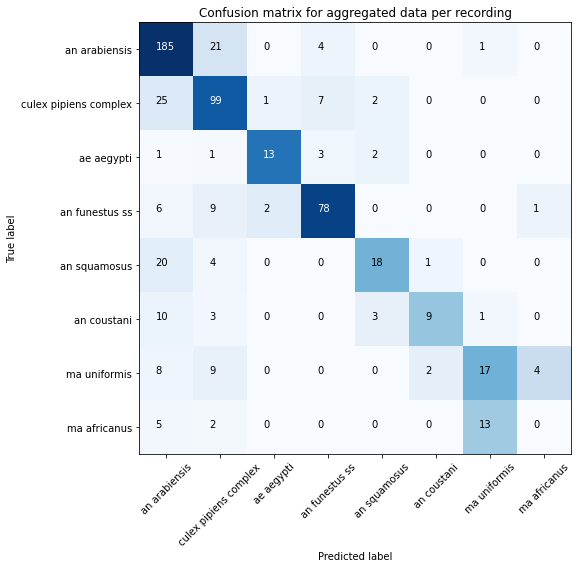

In [71]:
cnf_matrix = confusion_matrix(y_test, y_aggregated_prediction_by_mean)
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for aggregated data per recording', classes)
print(classification_report(y_test, y_aggregated_prediction_by_mean))

BNN
{0: 0.9068138903825231, 1: 0.895326001571092, 2: 0.9918421052631579, 3: 0.9676113360323887, 4: 0.8888652693337868, 5: 0.9555373704309875, 6: 0.9122727272727272, 7: 0.8913157894736843, 'micro': 0.939585504986252}


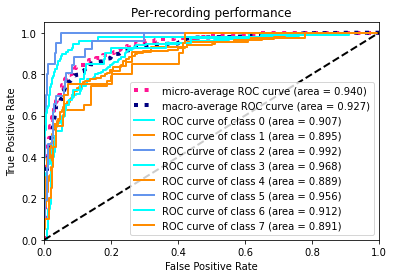

In [72]:
compute_plot_roc_multiclass(y_test,np.array(preds_aggregated_by_mean), classes, title='Per-recording performance')